<center><font size=6> Bank Churn Prediction </font></center>

## Problem Statement

### Context

Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### Objective

You as a Data scientist with the  bank need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### Data Dictionary

* CustomerId: Unique ID which is assigned to each customer

* Surname: Last name of the customer

* CreditScore: It defines the credit history of the customer.
  
* Geography: A customer’s location
   
* Gender: It defines the Gender of the customer
   
* Age: Age of the customer
    
* Tenure: Number of years for which the customer has been with the bank

* NumOfProducts: refers to the number of products that a customer has purchased through the bank.

* Balance: Account balance

* HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

* EstimatedSalary: Estimated salary

* isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

* Exited : whether or not the customer left the bank within six month. It can take two values
** 0=No ( Customer did not leave the bank )
** 1=Yes ( Customer left the bank )

## Importing necessary libraries

In [ ]:
#Installing the libraries with the specified version.
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 matplotlib===3.7.1 seaborn==0.13.1 numpy==1.25.2 pandas==2.0.3 -q --user

In [ ]:
import pandas as pd  # Library for data manipulation and analysis.
import numpy as np   # Fundamental package for scientific computing.
import matplotlib.pyplot as plt  # Plotting library for creating visualizations.
import seaborn as sns #For advanced visualizations.

from sklearn.model_selection import train_test_split  # Function for splitting datasets for training and testing.

import time  # Module for time-related operations.

import tensorflow as tf #An end-to-end open source machine learning platform
from tensorflow import keras  # High-level neural networks API for deep learning.
from keras import backend   # Abstraction layer for neural network backend engines.
from keras.models import Sequential  # Model for building NN sequentially.
from keras.layers import Dense   # for creating fully connected neural network layers.
from keras.utils import to_categorical
from keras import optimizers
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import losses
from keras.layers import Dropout
from keras.layers import BatchNormalization

# to split the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics

import random

# import tensorflow_addons as tfa

from keras.metrics import Recall, F1Score

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
# Ignoring warnings that are not critical for clarity in reports, though it's generally not recommended for production code
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Adjusting pandas display settings for better dataframe visibility
pd.set_option("display.max_columns", None)  # No limit on the number of displayed columns
pd.set_option("display.max_rows", 200)  # Displays up to 200 rows
pd.set_option("display.float_format", lambda x: "%.3f" % x)  # Suppress scientific notation




In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it might affect the overall performance
tf.config.experimental.enable_op_determinism()

### Utility functions
We will use these custom functions in our EDA and report

In [ ]:
# Function to plot loss/metrics
def plot(history, name):
    """
    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train accuracy or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

In [ ]:
# Function to create Histogram and Boxplot together

def histogram_boxplot(data, feature, figsize=(12, 7), kde=True, bins=None):
    """
    Creates a combined plot with a boxplot on top and a histogram below for the specified feature.

    Parameters:
    - data: DataFrame containing the data.
    - feature: String name of the column in `data` for which the plots will be made.
    - figsize: Tuple specifying the figure size. Default is (12, 7).
    - kde: Boolean indicating whether to overlay a kernel density estimate on the histogram. Default is True.
    - bins: Number of bins for the histogram. If None, the bin size will be determined automatically. Default is None.
    """

    # Create a figure with two subplots (rows) and share the x-axis
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (0.2, 0.8)}, figsize=figsize)

    # Boxplot
    sns.boxplot(data=data, x=feature, ax=ax_box, showmeans=True, color="skyblue", meanprops={"marker":"d", "markerfacecolor":"red", "markeredgecolor":"black"})
    ax_box.set(xlabel='')  # Remove the x-axis label for the boxplot

    # Histogram
    if bins:
      sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist, bins=bins, color="lightgreen")
    else:
      sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist)

    # Mean and median lines
    mean_value = data[feature].mean()
    median_value = data[feature].median()
    ax_hist.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
    ax_hist.axvline(median_value, color='b', linestyle='-', label=f'Median: {median_value:.2f}')

    # Legend for the histogram
    ax_hist.legend()

    # Title for the histogram to avoid overlap with the boxplot
    ax_hist.set_title(f'Distribution of {feature}')

    # Tight layout to ensure neatness
    plt.tight_layout()


In [ ]:
# Function to create labeled barplot

def labeled_barplot(data, feature, perc=False, n=None, sort_values=True, custom_palette="Paired", title=None, xlabel=None, ylabel="Count"):
    """
    Enhanced bar plot with labels showing count or percentage.

    Parameters:
    - data: DataFrame containing the data.
    - feature: String specifying the column in `data` to plot.
    - perc: Boolean, if True, display percentages instead of counts. Default is False.
    - n: Integer, display the top n categories. Default is None, displaying all categories.
    - sort_values: Boolean, if True, sort categories by their count/percentage. Default is True.
    - custom_palette: Color palette name or list. Default is "Paired".
    - title: String, the title of the plot. Default is None.
    - xlabel: String, the label for the x-axis. Default is None (will use `feature`).
    - ylabel: String, the label for the y-axis. Default is "Count".
    """
    if feature not in data.columns:
        raise ValueError(f"{feature} is not a column in the provided DataFrame.")

    if n is not None:
        data = data[data[feature].isin(data[feature].value_counts().index[:n])]

    # order = data[feature].value_counts().nlargest(n if n is not None else len(data)).index
    # if sort_values and n is None:
    #     order = order.sort_values()

    # Determine the order of categories to display
    value_counts = data[feature].value_counts()
    if n is not None:
        value_counts = value_counts.nlargest(n)
    order = value_counts.index

    plt.figure(figsize=((min(len(order) * 1.2, 20)), 7))
    ax = sns.countplot(data=data, x=feature, palette=custom_palette, order=order)

    plt.xticks(rotation=45, fontsize=12)
    ax.set_title(title if title else f'Distribution of {feature}', fontsize=15)
    ax.set_xlabel(xlabel if xlabel else feature, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    total = data[feature].count() if perc else 1  # Corrected for percentage calculations
    for p in ax.patches:
        label = "{:.1f}%".format(100 * p.get_height() / total) if perc else p.get_height()
        ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, textcoords="offset points", xytext=(0,10), weight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
### function to plot distributions wrt target

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [ ]:
### function to plot distributions wrt target - Dynamic Handling of Unique Target Values

import seaborn as sns
import matplotlib.pyplot as plt

def distribution_plot_wrt_target_dynamic(data, predictor, target):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    # Ensure there's at least one unique target value
    if len(target_uniq) > 0:
        axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
        sns.histplot(
            data=data[data[target] == target_uniq[0]],
            x=predictor,
            kde=True,
            ax=axs[0, 0],
            color="teal",
            stat="density",
        )

    # Check if there's a second unique target value
    if len(target_uniq) > 1:
        axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
        sns.histplot(
            data=data[data[target] == target_uniq[1]],
            x=predictor,
            kde=True,
            ax=axs[0, 1],
            color="orange",
            stat="density",
        )

    # Boxplots can handle one or more unique values without modification
    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()


In [ ]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a neural network model
def model_performance_linear(model,predictors,target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """
    # predicting using the independent variables
    pred = model.predict(predictors).reshape(-1)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf =  {
            "RMSE": [rmse],
            "MAE": [mae],
            "R-squared": [r2],
            "Adj. R-squared": [adjr2],
            "MAPE": [mape]}

    return df_perf

columns = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer ","# epochs","batch size","Optimizer", "SMOTE", "Dropout","Train_loss","Valid_loss","Train_Recall","Validation_Recall","time (secs)"]

results = pd.DataFrame(columns=columns)

In [ ]:
## Function to create confusion matrix
import numpy as np
from sklearn import metrics
import pandas as pd

def display_confusion_matrix(model, X_test, y_actual, labels=[1, 0]):
    '''
    model : classifier to predict values of X
    X_test : Test data for prediction
    y_actual : ground truth

    '''
    # Assume model_6 is your trained model and X_test is your test dataset
    y_predict_probs = model.predict(X_test)

    # Convert probabilities to binary predictions
    # Assuming your model outputs one probability per instance (common in binary classification)
    y_predict = (y_predict_probs > 0.5).astype(int)

    cm = metrics.confusion_matrix(y_actual, y_predict, labels=labels)
    df_cm = pd.DataFrame(cm, index=[i for i in ["Actual - No", "Actual - Yes"]],
                         columns=[i for i in ['Predicted - No', 'Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_binary(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors) > threshold
    # pred_temp = model.predict(predictors) > threshold
    # # rounding off the above values to get classes
    # pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},
        index=[0],
    )

    return df_perf

## Loading the data

In [ ]:
#Loading the dataset from tensorflow datasets.
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Run the following lines let Google Colab access my google drive
from google.colab import drive
drive.mount('/content/drive')

originalData = pd.read_csv("/content/drive/MyDrive/GreatLearning/Churn.csv") ##  Code to read the data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# copying data to another variable to avoid any changes to original data
data = originalData.copy()

## Data Overview

### Guidelines for Observations & Sanity checks
The initial steps to get an overview of any dataset is to:
- Observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- Get information about the number of rows and columns in the dataset
- Find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- Check the statistical summary of the dataset to get an overview of the numerical columns of the data


### Check shape of the dataset.

In [ ]:
data.shape ##  Code to view dimensions of the data

(10000, 14)

Observation
* 10000 customers data
* 14 attributes

In [ ]:
# Check first 5 rows
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


In [ ]:
# Check last 5 rows
data.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.000,2,1,0,96270.640,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.610,1,1,1,101699.770,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.000,1,0,1,42085.580,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.310,2,1,0,92888.520,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.790,1,1,0,38190.780,0


### Check the data types of the columns in this dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#### Observation
* No missing data in first impression
* 3 objects and 11 numerical columns

### Check for duplicates

In [ ]:
# Let's check if any duplicate orders in data
data.duplicated().sum()

0

Observation:
* No duplicates

### Check for Missing values

In [ ]:
# checking missing values in the data
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

* No missing values

### Checking the Statistical Summary

In [ ]:
# Get stats
#data.describe().T
data.describe(include='all').T  # To get all columns

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000.000,NaN,NaN,NaN,5000.500,2886.896,1.000,2500.750,5000.500,7500.250,10000.000
CustomerId,10000.000,NaN,NaN,NaN,15690940.569,71936.186,15565701.000,15628528.250,15690738.000,15753233.750,15815690.000
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.000,NaN,NaN,NaN,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.000,NaN,NaN,NaN,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,10000.000,NaN,NaN,NaN,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Balance,10000.000,NaN,NaN,NaN,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
NumOfProducts,10000.000,NaN,NaN,NaN,1.530,0.582,1.000,1.000,1.000,2.000,4.000


In [ ]:
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Get unique values for each column
for cat_column in categorical_columns:
    print(f"Unique values in {cat_column}: {data[cat_column].unique()}")
    print("-" * 40)

Unique values in Surname: ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
----------------------------------------
Unique values in Geography: ['France' 'Spain' 'Germany']
----------------------------------------
Unique values in Gender: ['Female' 'Male']
----------------------------------------


In [ ]:
data.CustomerId.value_counts()

CustomerId
15634602    1
15667932    1
15766185    1
15667632    1
15599024    1
           ..
15599078    1
15702300    1
15660735    1
15671390    1
15628319    1
Name: count, Length: 10000, dtype: int64

In [ ]:
data.CustomerId.nunique()

10000

In [ ]:
data.Surname.nunique()

2932

In [ ]:
data.HasCrCard.value_counts()

HasCrCard
1    7055
0    2945
Name: count, dtype: int64

In [ ]:
data.IsActiveMember.value_counts()

IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

**Key Observations**

* Dataset contains 10000 customers data with 14 attributes
* RowNumber: Just row num
* CustomerId: Customer Unique Identifier
* Surname: Categorical var. Last name of customer.
* CreditScore: Min as 350.0 and Max as 850. Mean and Median are very close. Looks normal distribution
* Geography: Categorical var. 3 unique values: 'France' 'Spain' 'Germany'
* Gender: Categorical var. 2 unique values: Female, Male
* Age: Min age of customer is 18 and Max as 92 year old. Mean and Median are close. Looks normal distribution            
* Tenure: Bank has customers Number of years for which the customer has been with the bank. Min is 0 and Max as 10 year old. Mean and Median are same. Looks normal distribution            
* Balance: Min is 0 and Max is 250898. Mean is 76485 which lesser median (97198). Looks like left skewed distribution.
* NumOfProducts: Min is 1 and Max is 4. Mean is 1.5 which greater median (1). Looks like right skewed distribution.
* HasCrCard: Binary variable. 7055 customers has credit card from the bank.   
* IsActiveMember: Binary variable. 5151 customers are active with the bank.       
* EstimatedSalary: Min is 11 and Max is 199992. Mean and Median are close. Looks normal distribution.               
* Exited: Target var. Binary variable.

##Exploratory Data Analysis (EDA) Summary

### Please find the summary of EDA as below. The detailed EDA can be found in the <a href ="#scrollTo=9KgxRHBOy6fn&line=1&uniqifier=1">Appendix</a>.

<a id='eda'></a>
### <a id='link'>Summary of EDA</a>

* The dataset has 10000 bank's customers data with 14 attributes including CustomerId and Surname.
* 3 variables are object types and rest all are numerical types.
* No duplicate data.
* No missing values.
* Overall data looks clean/preprocessed

**Data Preprocessing**
* Dropped RowNumber, CustomerId and Surname because it might not add value to modeling.
* Scaling the data since it has a lot of outliers and to avoid dominance of features
* Splitting data in 3 sets train, validation and test with 60, 20, 20 split


### Key Observations

#### **Univariate Analysis**

**Credit Score**
* Distribution: Appears normally distributed with an average around 650.
* Actions: Suggesting cross-selling more services to customers with top scores (850) and monitoring those with very low scores. Considering that a significant number of customers have excellent credit scores, targeted offers could be beneficial.

**Credit Score Rating**
* Customer Profile: Many customers fall into the Poor to Good credit score categories.
* Recommendation: Proposing financial support like personal loans might help retain these customers. A predictive model to assess default risks could support this strategy effectively.

**Age**
* Distribution: Normal but right-skewed due to the presence of senior citizens.
* Insight: The age range primarily spans from 25 to 60 years, suggesting targeted marketing strategies for products suited to different life stages.

**Tenure**
* Distribution: Uniform, with an average customer tenure exceeding five years.
* Insight: This indicates a stable customer base; loyalty programs could further enhance retention.

**Balance**
* Notable Fact: 3,617 customers have zero balance.
* Query: Further investigation into the type of balances (savings or checking) and why such a high number have no balance could reveal important insights.

**Number of Products**
* Observation: Half of the customers use more than one bank product/service, with an average of 1.5 products per customer.
* Opportunity: There may be an opportunity to increase product uptake through bundling or more tailored marketing.

**Estimated Salary**
* Distribution: Uniform, with an average salary around £100,000.
* Implication: The broad range of salaries suggests that the bank serves a diverse demographic, potentially affecting product preferences and financial needs.

**Target Variable (Exited)**
* Churn Rate: Approximately 20% of customers have left the bank.
* Concern: The data is somewhat unbalanced with respect to churn, which may require oversampling or undersampling techniques during predictive modeling.

**Gender**
* Distribution: Slightly more male customers than female, fairly balanced.
* Consideration: Gender-specific marketing could be considered but should be approached carefully to avoid stereotypes.

**Geography**
* Distribution: Half of the customers are from France, with the remainder from Germany and Spain.
* Strategic Insight: France likely being the bank’s headquarters could influence product offerings and marketing strategies.

**Has Credit Card**
* Fact: 70% of customers possess a bank-issued credit card.
* Follow-Up: Investigating the link between credit card ownership, churn, and engagement with other bank services.

**IsActiveMember**
* Distribution: Evenly split between active and inactive members.
* Strategic Action: Identifying reasons for inactivity, particularly among credit card holders, could help in formulating engagement strategies.


#### **Bivariate Analysis**

**Correlation Heatmap**
* General Insight: No strong correlation is noted between any of the attributes and the churn, indicating that churn might be influenced by a combination of factors rather than a single attribute.
* Age and Balance: Slight positive correlations with customer churn suggest that older customers with higher balances are slightly more likely to churn.
* IsActiveMember: A slight negative correlation indicates that inactive members are more prone to churn.

**Age vs. Churn**
Older Customers Churning: Customers who churn are, on average, older than those who remain, suggesting potential dissatisfaction or better offers elsewhere as age increases.
Loyalty Among Seniors: Senior citizens tend to stay loyal, presenting an opportunity for targeted retention strategies for older customer segments.

**Gender vs. Churn**
Higher Churn in Females: Female customers are more likely to churn, indicating possible dissatisfaction or unmet needs among this demographic.

**Geography vs. Churn**
Regional Differences: Customers from Germany show a high churn rate, suggesting regional disparities in service satisfaction or market competition.
Focus on Germany: A strategic focus on improving services in Germany could reduce churn rates substantially. 814 customers from Germany who have exited. 577 customers with credit card and from Germany, who have exited.

**Tenure vs. Churn**
Low Impact of Tenure: Similar tenure distributions between those who stay and those who leave suggest tenure alone isn't a strong predictor of churn.

**Credit Card Holder vs. Churn**
Neutral Impact: Having a credit card does not significantly impact churn, although a majority of those who left had a credit card, suggesting potential areas for improving credit card services or benefits.

**IsActiveMember vs. Churn**
Inactive Members Churn More: A significant proportion of those who churn are inactive, highlighting the need for engagement strategies to reduce churn.

**Credit Score vs. Churn**
Minimal Impact: Similar credit score distributions among churned and retained customers suggest credit scores are not a decisive factor in churn.

**Balance vs. Churn**
Higher Balances and Churn: Customers with higher balances are more likely to churn, which could indicate competitive financial offerings elsewhere.
Target Mid to High Balance Holders: Special attention and tailored products for customers with balances over 50K could enhance retention.

**Estimated Salary vs. Churn**
Minimal Impact: Salary does not significantly affect churn, indicating that financial earnings alone do not influence customer retention.

**Number of Products vs. Churn**
Product Holdings and Churn: Customers with only one product or more than two are more likely to churn, suggesting dissatisfaction or unmet needs with the bank’s product offerings.



## Data Preprocessing

### Let's drop the few columns that wont add value in EDA

In [ ]:
# Get fresh copy of data
data2 = originalData.copy()

## drop the columns from the dataframe
data2 = data2.drop('RowNumber', axis=1)
data2 = data2.drop('CustomerId', axis=1)
data2 = data2.drop('Surname', axis=1)

In [ ]:
# Check data without ID
data2.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


In [ ]:
#Calculating the total number of nan values for each columns.
data2.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Feature Engineering

* New Column for to flag is customer has Zero Balance
* Credit Score Rating based on Credit Score

In [ ]:
data2['ZeroBalance'] = np.where(data2['Balance'] == 0, 1, 0)  # 'ZeroBalance' = 1 if 'Balance' is 0, otherwise 0

In [ ]:
# Define bins and labels
bins = [0, 580, 670, 740, 800, 850]
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']

# Create a new column with the binned categories
data2['CreditScoreRating'] = pd.cut(data2['CreditScore'], bins=bins, labels=labels, right=True)


In [ ]:
# Rename target variable in dataframe
data2 = data2.rename(columns={'Exited': 'target'})

In [ ]:
## Converting the data type of categorical features to 'category'
cat_cols = [
    "Gender",
    "Geography",
    "HasCrCard",
    "IsActiveMember",
    "CreditScoreRating",
    # "Exited"    # Target variable
]
data2[cat_cols] = data2[cat_cols].astype("category")    # Code to convert the cat_cols to category

**Let's check the count and percentage of categorical levels in each column**

In [ ]:
# Printing the count of unique categorical levels in each column
for column in cat_cols:
    print(data2[column].value_counts())
    print("-" * 50)

Gender
Male      5457
Female    4543
Name: count, dtype: int64
--------------------------------------------------
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
--------------------------------------------------
HasCrCard
1    7055
0    2945
Name: count, dtype: int64
--------------------------------------------------
IsActiveMember
1    5151
0    4849
Name: count, dtype: int64
--------------------------------------------------
CreditScoreRating
Fair         3350
Good         2397
Poor         2393
Very Good    1215
Excellent     645
Name: count, dtype: int64
--------------------------------------------------


### Train-validation-test Split
Split data in to train, valiation and test data in to 60, 20, 20 resp.

In [ ]:
data2.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,target,ZeroBalance,CreditScoreRating
0,619,France,Female,42,2,0.000,1,1,1,101348.880,1,1,Fair
1,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,0,Fair
2,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,0,Poor
3,699,France,Female,39,1,0.000,2,0,0,93826.630,0,1,Good
4,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0,0,Excellent


In [ ]:
# separating the independent and dependent variables. Any dependent to drop that wont contribute to model building?
X = data2.drop(["target"], axis=1)
y = data2["target"]

In [ ]:
# Splitting data into training, validation and test set:

# first we split data into 2 parts, say temporary and test : 80:20 Split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation.  : 75:25 Split
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)

print(X_train.shape, X_val.shape, X_test.shape)

(6000, 12) (2000, 12) (2000, 12)


In [ ]:
# Checking class balance for whole data, train set, validation set, and test set
print("Target value ratio in y")
print(y.value_counts(1))
print("*" * 80)
print("Target value ratio in y_train")
print(y_train.value_counts(1))
print("*" * 80)
print("Target value ratio in y_val")
print(y_val.value_counts(1))
print("*" * 80)
print("Target value ratio in y_test")
print(y_test.value_counts(1))
print("*" * 80)

Target value ratio in y
target
0   0.796
1   0.204
Name: proportion, dtype: float64
********************************************************************************
Target value ratio in y_train
target
0   0.796
1   0.204
Name: proportion, dtype: float64
********************************************************************************
Target value ratio in y_val
target
0   0.796
1   0.204
Name: proportion, dtype: float64
********************************************************************************
Target value ratio in y_test
target
0   0.796
1   0.203
Name: proportion, dtype: float64
********************************************************************************


### Dummy Variable Creation

In [ ]:
# X_train.info()

In [ ]:
X_train = pd.get_dummies(X_train, drop_first=True).astype(int)  # make sure to convert to int
X_val = pd.get_dummies(X_val, drop_first=True).astype(int)
X_test = pd.get_dummies(X_test, drop_first=True).astype(int)
print(X_train.shape, X_val.shape, X_test.shape)

(6000, 16) (2000, 16) (2000, 16)


In [ ]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,ZeroBalance,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard_1,IsActiveMember_1,CreditScoreRating_Fair,CreditScoreRating_Good,CreditScoreRating_Very Good,CreditScoreRating_Excellent
4472,660,23,6,166070,2,90494,0,1,0,0,0,0,1,0,0,0
4034,601,42,4,96763,1,199242,0,0,1,0,1,1,1,0,0,0
1454,521,34,7,70731,1,20243,0,0,1,0,1,1,0,0,0,0
9099,738,29,2,0,2,170421,1,0,0,1,1,1,0,1,0,0
2489,714,28,6,122724,1,67057,0,0,0,1,1,1,0,1,0,0


### One Hot Encoding the categorical variables

In [ ]:
# Identify categorical columns (You may need to adjust this)
# categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Preprocessing for numerical data: normalization
# numerical_transformer = StandardScaler()

# Preprocessing for categorical data: one-hot encoding
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')


### Outlier Detection

In [ ]:
# data2.describe().T

In [ ]:
# Find the percentage of outlier values for each numeric column in the dataset
# Identify the percentage of outliers based on quantiles
# Define the quantiles for the lower and upper bounds directly within the calculation
lower_quantile = 0.25
upper_quantile = 0.75

# Calculate the quantile values for all numeric columns in the DataFrame
lower_quantile_data = data2.select_dtypes(include=["float64", "int64"]).quantile(lower_quantile)
upper_quantile_data = data2.select_dtypes(include=["float64", "int64"]).quantile(upper_quantile)

# Calculate the percentage of values outside the quantile bounds for each numeric column
outlier_percentage = ((data2.select_dtypes(include=["float64", "int64"]) < lower_quantile_data) |
                      (data2.select_dtypes(include=["float64", "int64"]) > upper_quantile_data)).sum() / len(data) * 100

# Display the percentage of outliers
print(outlier_percentage)

CreditScore       49.540
Age               47.120
Tenure            49.950
Balance           25.000
NumOfProducts      3.260
EstimatedSalary   50.000
target            20.370
ZeroBalance        0.000
dtype: float64


In [ ]:
# lower_quantile_data

In [ ]:
# upper_quantile_data

**Observation**
* Too many outliers but looks valid data so we can't ignore this while model building.
* We can normalize data before building model

### Data Normalization
* Normalizing the numerical variables

In [ ]:
%%time
#Standardizing the numerical variables to zero mean and unit variance.
transformer = StandardScaler()

X_train[["CreditScore","Age","Tenure","Balance","NumOfProducts", "EstimatedSalary"]] = transformer.fit_transform(X_train[["CreditScore","Age","Tenure","Balance","NumOfProducts", "EstimatedSalary"]])

X_val[["CreditScore","Age","Tenure","Balance","NumOfProducts", "EstimatedSalary"]] = transformer.transform(X_val[["CreditScore","Age","Tenure","Balance","NumOfProducts", "EstimatedSalary"]])
X_test[["CreditScore","Age","Tenure","Balance","NumOfProducts", "EstimatedSalary"]] = transformer.transform(X_test[["CreditScore","Age","Tenure","Balance","NumOfProducts", "EstimatedSalary"]])

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 16.2 ms


In [ ]:
# X_train = np.asarray(X_train).astype(np.float32)

In [ ]:
# X_train.info()

We'll create a dataframe to store the results from all the models we build

In [ ]:
#Defining the columns of the dataframe which are nothing but the hyper parameters and the metrics.
columns = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer","# epochs","batch size", "Optimizer", "SMOTE", "Dropout", "train loss","validation loss","train recall","validation recall","time (secs)"]

#Creating a pandas dataframe.
results = pd.DataFrame(columns=columns)

## Model Building
We want to build a classifier model because we want to classify whether a customer will leave the bank (target =1) or not (target = 0). Decision Trees are often used for classification tasks where the goal is to predict which category or class (target) a particular observation belongs to based on its features.

### Model Evaluation Criterion

**Model can make wrong predictions as:**

   * Precticting a customer will stop using Bank's service but actually customer will not stop using Bank's service. - Loss of resources
   * Precticting a customer will not stop using Bank's service but actually customer will stop using Bank's service. - Loss of a customer/business

**What does the Bank want?**
  * Bank wants to minimize the loss - it can face 2 types of losses as mentioned above. Loosing a customer's business is greater loss but also Bank want to provide better service to loyal customers and increase customer satisfaction. That would lead to more customer's engagement and potential opportunities for growth of business.

**Since we want to reduce loss and also provide better service to loyal customers we should use F1 score as a metric of model evaluation instead of accuracy or recall only.**

* F1 - F1 score balances between Recall and Precision, it it will help to reduce False Negatives as well as False Positives.

## Initial Model Building

### Neural Network with SGD Optimizer

As we have are dealing with an imbalance in class distribution, we will be using class weights to allow the model to give proportionally more importance to the minority class.

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [ ]:
y_train.value_counts()

target
0    4778
1    1222
Name: count, dtype: int64

In [ ]:
# Calculate class weights for imbalanced dataset
cw = (y_train.shape[0]) / np.bincount(y_train)

# Create a dictionary mapping class indices to their respective class weights
cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[i] = cw[i]

cw_dict

{0: 1.2557555462536627, 1: 4.909983633387888}

In [ ]:
# defining the batch size and # epochs upfront as we'll be using the same values for all models
epochs = 24
batch_size = 64

- Let's start with a neural network consisting of
  - two hidden layers with 14 and 7 neurons respectively
  - activation function of ReLU.
  - SGD as the optimizer

In [ ]:
# !pip install tensorflow-addons


In [ ]:

#Initializing the neural network model
model_0 = Sequential()
# Adding input layer
model_0.add(Dense(64,activation="relu",input_dim=X_train.shape[1]))
# Adding first hidden layer
model_0.add(Dense(32,activation="relu"))
# Adding output layer
model_0.add(Dense(1,activation="sigmoid"))  # using sigmoid because target variable is binary class var

# Defining the SGD Optimizers
SGD = optimizers.SGD(learning_rate=1e-3)    # learning_rate = 0.001


metric = keras.metrics.Recall()

# metric = keras.metrics.F1Score()
# metrics=[
#         'accuracy',
#         tf.keras.metrics.Recall(name='recall'),
#         tfa.metrics.F1Score(num_classes=1, threshold=0.5, name='f1_score')
#     ]



**NOTE**
* Getting error with **F1Score** as below so changed to use metrics **Recall** to track metrics in history
* ValueError: Tensor conversion requested dtype float32 for Tensor with dtype int64: <tf.Tensor 'IteratorGetNext:1' shape=(None, 1) dtype=int64>

In [ ]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compiling the model with categorical crossentropy as loss function with desired metrics
model_0.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=SGD, metrics=[metric])

In [ ]:
start = time.time()
history_0 = model_0.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/24
94/94 [==============================] - 2s 9ms/step - loss: 1.3956 - recall: 0.2823 - val_loss: 0.6660 - val_recall: 0.3113
Epoch 2/24
94/94 [==============================] - 0s 4ms/step - loss: 1.3835 - recall: 0.3355 - val_loss: 0.6636 - val_recall: 0.3578
Epoch 3/24
94/94 [==============================] - 0s 5ms/step - loss: 1.3724 - recall: 0.3813 - val_loss: 0.6608 - val_recall: 0.3946
Epoch 4/24
94/94 [==============================] - 1s 7ms/step - loss: 1.3623 - recall: 0.4206 - val_loss: 0.6579 - val_recall: 0.4412
Epoch 5/24
94/94 [==============================] - 0s 4ms/step - loss: 1.3528 - recall: 0.4599 - val_loss: 0.6549 - val_recall: 0.4877
Epoch 6/24
94/94 [==============================] - 0s 3ms/step - loss: 1.3438 - recall: 0.4926 - val_loss: 0.6515 - val_recall: 0.5098
Epoch 7/24
94/94 [==============================] - 0s 3ms/step - loss: 1.3354 - recall: 0.5229 - val_loss: 0.6482 - val_recall: 0.5270
Epoch 8/24
94/94 [==============================

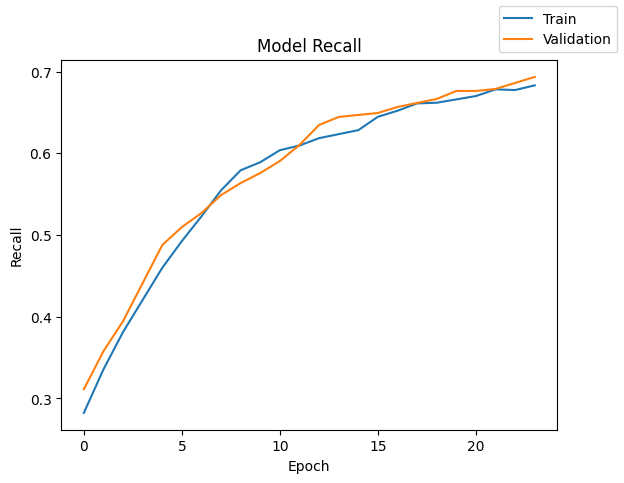

In [ ]:
plot(history_0,'recall')

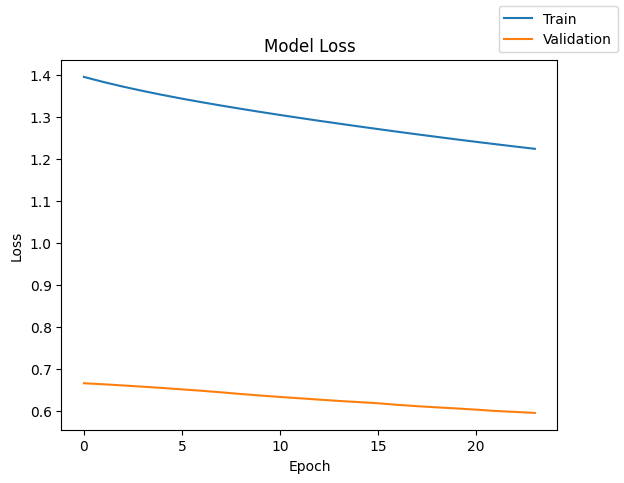

In [ ]:
plot(history_0,'loss')

In [ ]:
# Checking model's performance on training set
model_0_train_perf = model_performance_classification_binary(model_0, X_train, y_train)
model_0_train_perf

188/188 [==============================] - 1s 2ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.702,0.702,0.790,0.728


In [ ]:
model_0_valid_perf = model_performance_classification_binary(model_0, X_val, y_val)
model_0_valid_perf

63/63 [==============================] - 0s 4ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.697,0.697,0.791,0.724


- Train F1 score of ~0.73 and test F1 score of ~0.71 indicate consistent performance of the model between training and testing datasets.

- Even though it's a good score, the rate of improvement over the epochs is still low.

In [ ]:
# columns = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer ","# epochs","batch size","Optimizer", "SMOTE", "Dropout","Train_loss","Valid_loss","Train_Recall","Validation_Recall","time (secs)"]

results.loc[0] = [1,32,'Sigmoid',24,"64","SGD","No","No",history_0.history["loss"][-1],history_0.history["val_loss"][-1],history_0.history["recall"][-1],history_0.history["val_recall"][-1],round(end-start,2)]
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,Optimizer,SMOTE,Dropout,train loss,validation loss,train recall,validation recall,time (secs)
0,1,32,Sigmoid,24,64,SGD,No,No,1.224,0.595,0.683,0.694,21.570


## Model Performance Improvement

### Neural Network with Adam Optimizer


- Let's change the optimizer to Adam
    - This will introduce momentum as well as an adaptive learning rate

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [ ]:
# defining the batch size and # epochs upfront as we'll be using the same values for all models
epochs = 24
batch_size = 64

In [ ]:
#Initializing the neural network model
model_1 = Sequential()
# Adding input layer
model_1.add(Dense(64,activation="relu",input_dim=X_train.shape[1]))
# Adding first hidden layer
model_1.add(Dense(32,activation="relu"))
# Adding output layer
model_1.add(Dense(1,activation="sigmoid"))  # using sigmoid because target variable is binary class var

# Defining the Adam Optimizers
Adam = optimizers.Adam(learning_rate=1e-3)    # learning_rate = 0.001

metric = keras.metrics.Recall()
# metric = keras.metrics.F1Score()

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compiling the model with categorical crossentropy as loss function with accuracy as metrics
model_1.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=Adam, metrics=[metric])

In [ ]:
start = time.time()
history_1 = model_1.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/24
94/94 [==============================] - 4s 22ms/step - loss: 1.2261 - recall: 0.6620 - val_loss: 0.6050 - val_recall: 0.7917
Epoch 2/24
94/94 [==============================] - 1s 8ms/step - loss: 1.0782 - recall: 0.7586 - val_loss: 0.4859 - val_recall: 0.7500
Epoch 3/24
94/94 [==============================] - 1s 8ms/step - loss: 1.0029 - recall: 0.7766 - val_loss: 0.5085 - val_recall: 0.8015
Epoch 4/24
94/94 [==============================] - 1s 9ms/step - loss: 0.9620 - recall: 0.7692 - val_loss: 0.4392 - val_recall: 0.7426
Epoch 5/24
94/94 [==============================] - 1s 12ms/step - loss: 0.9368 - recall: 0.7733 - val_loss: 0.4477 - val_recall: 0.7451
Epoch 6/24
94/94 [==============================] - 1s 6ms/step - loss: 0.9241 - recall: 0.7717 - val_loss: 0.4628 - val_recall: 0.7696
Epoch 7/24
94/94 [==============================] - 0s 5ms/step - loss: 0.9127 - recall: 0.7758 - val_loss: 0.4680 - val_recall: 0.7745
Epoch 8/24
94/94 [============================

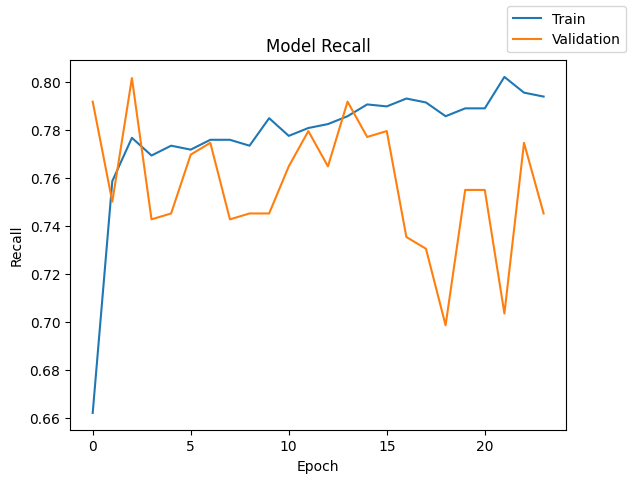

In [ ]:
plot(history_1,'recall')

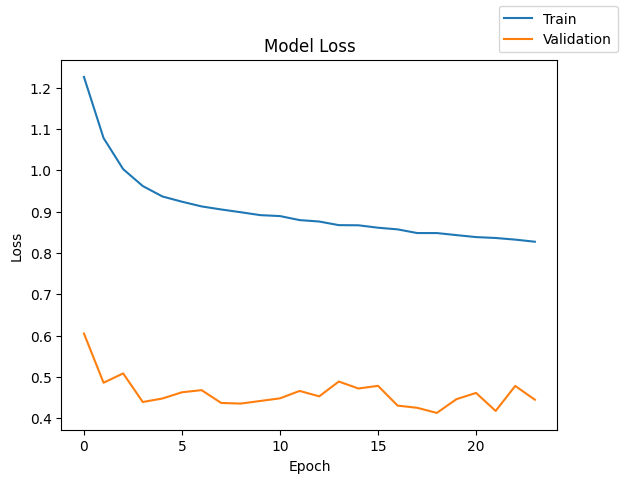

In [ ]:
plot(history_1,'loss')

In [ ]:
# Checking model's performance on training set
model_1_train_perf = model_performance_classification_binary(model_1, X_train, y_train)
model_1_train_perf

188/188 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.817,0.817,0.858,0.829


In [ ]:
model_1_valid_perf = model_performance_classification_binary(model_1, X_val, y_val)
model_1_valid_perf

63/63 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.796,0.796,0.839,0.810


- Train F1 score of ~0.73 and test F1 score of ~0.71 indicate consistent performance of the model between training and testing datasets.

- Even though it's a good score, the rate of improvement over the epochs is still low.

In [ ]:
# columns = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer ","# epochs","batch size","Optimizer", "SMOTE", "Dropout","Train_loss","Valid_loss","Train_Recall","Validation_Recall","time (secs)"]

results.loc[1] = [1,32,'Sigmoid',24,"64","Adam","No","No",history_1.history["loss"][-1],history_1.history["val_loss"][-1],history_1.history["recall"][-1],history_1.history["val_recall"][-1],round(end-start,2)]
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,Optimizer,SMOTE,Dropout,train loss,validation loss,train recall,validation recall,time (secs)
0,1,32,Sigmoid,24,64,SGD,No,No,1.224,0.595,0.683,0.694,21.570
1,1,32,Sigmoid,24,64,Adam,No,No,0.827,0.445,0.794,0.745,22.510


### Neural Network with Adam Optimizer and Dropout

- Let's use Adam optimizer with Dropout with 0.5 rate.
    - Keep model param same as previous
- Dropout: Added after each hidden layer to help prevent overfitting.
    
Note: Dropout rate of 0.5 is commonly used, but this should be tuned based on specific needs and may vary between different layers or models.

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [ ]:
# defining the batch size and # epochs upfront as we'll be using the same values for all models
epochs = 24
batch_size = 64

In [ ]:
#Initializing the neural network model
model_2 = Sequential()
# Adding input layer
model_2.add(Dense(64,activation="relu",input_dim=X_train.shape[1]))
# Adding Dropout
model_2.add(Dropout(0.5))  # 50% Dropout rate
# Adding first hidden layer
model_2.add(Dense(32,activation="relu"))
# Adding Dropout
model_2.add(Dropout(0.2))  # 20% Dropout rate
# Adding output layer
model_2.add(Dense(1,activation="sigmoid"))  # using sigmoid because target variable is binary class var

# Defining the Adam Optimizers
Adam = optimizers.Adam(learning_rate=1e-3)    # learning_rate = 0.001

metric = keras.metrics.Recall()
# metric = keras.metrics.F1Score()

In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compiling the model with categorical crossentropy as loss function with accuracy as metrics
model_2.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=Adam, metrics=[metric])

In [ ]:
start = time.time()
history_2 = model_2.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/24
94/94 [==============================] - 1s 5ms/step - loss: 1.3055 - recall: 0.6465 - val_loss: 0.6103 - val_recall: 0.6936
Epoch 2/24
94/94 [==============================] - 0s 3ms/step - loss: 1.2018 - recall: 0.6964 - val_loss: 0.5523 - val_recall: 0.6912
Epoch 3/24
94/94 [==============================] - 0s 3ms/step - loss: 1.1650 - recall: 0.7144 - val_loss: 0.5314 - val_recall: 0.7132
Epoch 4/24
94/94 [==============================] - 0s 3ms/step - loss: 1.1082 - recall: 0.7324 - val_loss: 0.5030 - val_recall: 0.7279
Epoch 5/24
94/94 [==============================] - 0s 3ms/step - loss: 1.0832 - recall: 0.7218 - val_loss: 0.5029 - val_recall: 0.7500
Epoch 6/24
94/94 [==============================] - 0s 3ms/step - loss: 1.0723 - recall: 0.7185 - val_loss: 0.5018 - val_recall: 0.7574
Epoch 7/24
94/94 [==============================] - 0s 3ms/step - loss: 1.0409 - recall: 0.7398 - val_loss: 0.5082 - val_recall: 0.7868
Epoch 8/24
94/94 [==============================

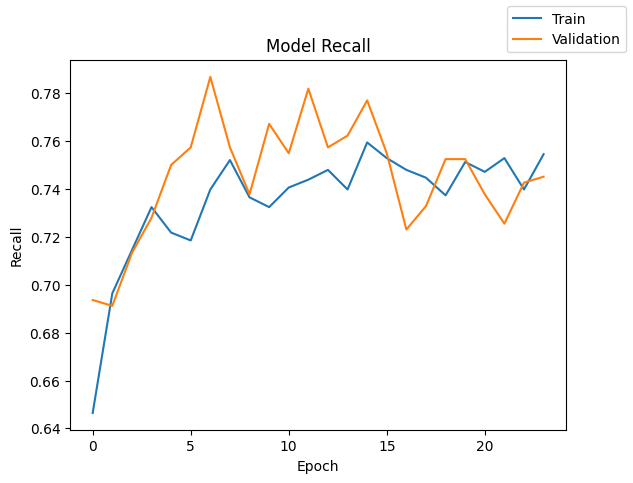

In [ ]:
plot(history_2,'recall')

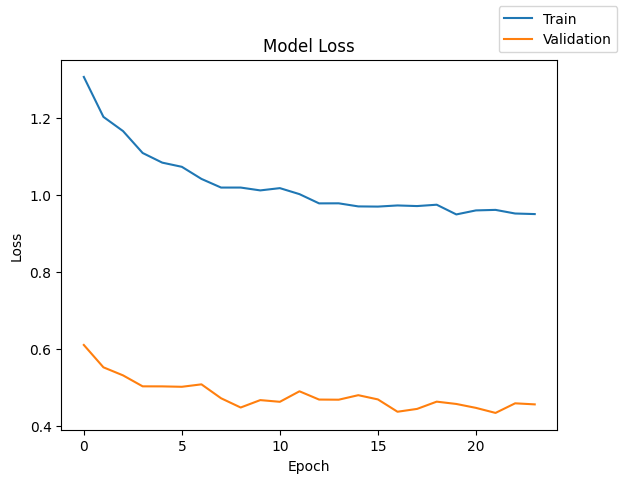

In [ ]:
plot(history_2,'loss')

In [ ]:
# Checking model's performance on training set
model_2_train_perf = model_performance_classification_binary(model_2, X_train, y_train)
model_2_train_perf

188/188 [==============================] - 0s 2ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.798,0.798,0.841,0.811


In [ ]:
model_2_valid_perf = model_performance_classification_binary(model_2, X_val, y_val)
model_2_valid_perf

63/63 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.792,0.792,0.837,0.806


- Train F1 score of ~0.73 and test F1 score of ~0.71 indicate consistent performance of the model between training and testing datasets.

- Even though it's a good score, the rate of improvement over the epochs is still low.

In [ ]:
# columns = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer","# epochs","batch size", "Optimizer", "train loss","validation loss","train accuracy","validation accuracy","time (secs)"]

results.loc[2] = [1,32,'Sigmoid',24,"64","Adam","No","Yes", history_2.history["loss"][-1],history_2.history["val_loss"][-1],history_2.history["recall"][-1],history_2.history["val_recall"][-1],round(end-start,2)]
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,Optimizer,SMOTE,Dropout,train loss,validation loss,train recall,validation recall,time (secs)
0,1,32,Sigmoid,24,64,SGD,No,No,1.224,0.595,0.683,0.694,21.570
1,1,32,Sigmoid,24,64,Adam,No,No,0.827,0.445,0.794,0.745,22.510
2,1,32,Sigmoid,24,64,Adam,No,Yes,0.950,0.456,0.755,0.745,8.810


### Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer

- Let's SMOTE to balance the data and use SGD Optimizer
  - Using the Synthetic Minority Over-sampling Technique (SMOTE) for handling class imbalance

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [ ]:
%%time
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of X_train: {}".format(X_train_over.shape))
print("After Oversampling, the shape of y_train: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 1222
Before Oversampling, counts of label 'No': 4778 

After Oversampling, counts of label 'Yes': 4778
After Oversampling, counts of label 'No': 4778 

After Oversampling, the shape of X_train: (9556, 16)
After Oversampling, the shape of y_train: (9556,) 

CPU times: user 72.5 ms, sys: 11.1 ms, total: 83.6 ms
Wall time: 81.5 ms


In [ ]:
# Recalculate class weights for imbalanced dataset and verify
cw = (y_train_over.shape[0]) / np.bincount(y_train_over)

# Create a dictionary mapping class indices to their respective class weights
cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[i] = cw[i]

cw_dict

{0: 2.0, 1: 2.0}

In [ ]:
# defining the batch size and # epochs upfront as we'll be using the same values for all models
epochs = 24
batch_size = 64

In [ ]:
#Initializing the neural network model
model_3 = Sequential()
# Adding input layer
model_3.add(Dense(64,activation="relu",input_dim=X_train.shape[1]))
# Adding first hidden layer
model_3.add(Dense(32,activation="relu"))
# Adding output layer
model_3.add(Dense(1,activation="sigmoid"))  # using sigmoid because target variable is binary class var

# Defining the SGD Optimizers
SGD = optimizers.SGD(learning_rate=1e-3)    # learning_rate = 0.001

metric = keras.metrics.Recall()
# metric = keras.metrics.F1Score()

In [ ]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compiling the model with categorical crossentropy as loss function with accuracy as metrics
model_3.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=SGD, metrics=[metric])

In [ ]:
start = time.time()
history_3 = model_3.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/24
94/94 [==============================] - 1s 5ms/step - loss: 1.3147 - recall: 0.2447 - val_loss: 0.6189 - val_recall: 0.1471
Epoch 2/24
94/94 [==============================] - 0s 3ms/step - loss: 1.2068 - recall: 0.0933 - val_loss: 0.5764 - val_recall: 0.0539
Epoch 3/24
94/94 [==============================] - 0s 3ms/step - loss: 1.1393 - recall: 0.0237 - val_loss: 0.5490 - val_recall: 0.0147
Epoch 4/24
94/94 [==============================] - 0s 3ms/step - loss: 1.0953 - recall: 0.0057 - val_loss: 0.5309 - val_recall: 0.0049
Epoch 5/24
94/94 [==============================] - 0s 3ms/step - loss: 1.0658 - recall: 0.0016 - val_loss: 0.5185 - val_recall: 0.0000e+00
Epoch 6/24
94/94 [==============================] - 0s 3ms/step - loss: 1.0447 - recall: 8.1833e-04 - val_loss: 0.5094 - val_recall: 0.0000e+00
Epoch 7/24
94/94 [==============================] - 0s 3ms/step - loss: 1.0288 - recall: 8.1833e-04 - val_loss: 0.5024 - val_recall: 0.0000e+00
Epoch 8/24
94/94 [==========

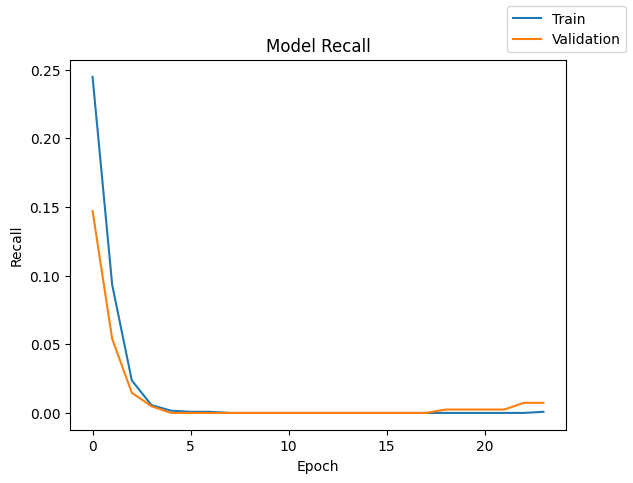

In [ ]:
plot(history_3,'recall')

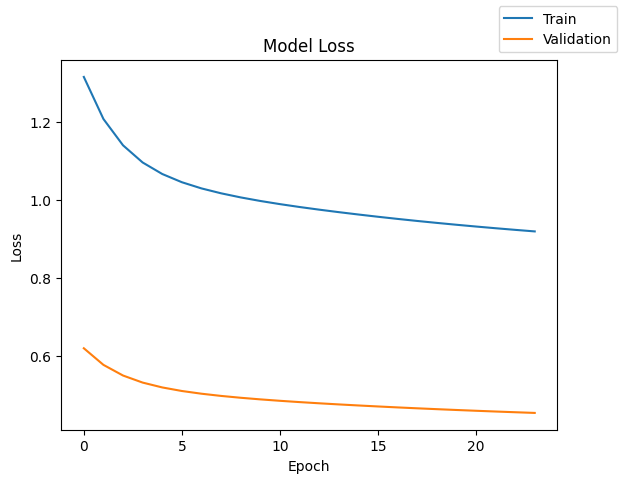

In [ ]:
plot(history_3,'loss')

In [ ]:
# Checking model's performance on training set
model_3_train_perf = model_performance_classification_binary(model_3, X_train, y_train)
model_3_train_perf

188/188 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.797,0.797,0.838,0.707


In [ ]:
model_3_valid_perf = model_performance_classification_binary(model_3, X_val, y_val)
model_3_valid_perf

63/63 [==============================] - 0s 2ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.797,0.797,0.839,0.709


- Train F1 score of ~0.73 and test F1 score of ~0.71 indicate consistent performance of the model between training and testing datasets.

- Even though it's a good score, the rate of improvement over the epochs is still low.

In [ ]:
# columns = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer ","# epochs","batch size","Optimizer", "SMOTE", "Dropout","Train_loss","Valid_loss","Train_Recall","Validation_Recall","time (secs)"]

results.loc[3] = [1,32,'Sigmoid',24,"64","SGD","Yes","No",history_3.history["loss"][-1],history_3.history["val_loss"][-1],history_3.history["recall"][-1],history_3.history["val_recall"][-1],round(end-start,2)]
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,Optimizer,SMOTE,Dropout,train loss,validation loss,train recall,validation recall,time (secs)
0,1,32,Sigmoid,24,64,SGD,No,No,1.224,0.595,0.683,0.694,21.570
1,1,32,Sigmoid,24,64,Adam,No,No,0.827,0.445,0.794,0.745,22.510
2,1,32,Sigmoid,24,64,Adam,No,Yes,0.950,0.456,0.755,0.745,8.810
3,1,32,Sigmoid,24,64,SGD,Yes,No,0.919,0.453,0.001,0.007,7.200


### Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer

- Let's SMOTE to balance the data and use Adam Optimizer
  - Using the Synthetic Minority Over-sampling Technique (SMOTE) for handling class imbalance

In [ ]:
%%time
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of X_train: {}".format(X_train_over.shape))
print("After Oversampling, the shape of y_train: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 1222
Before Oversampling, counts of label 'No': 4778 

After Oversampling, counts of label 'Yes': 4778
After Oversampling, counts of label 'No': 4778 

After Oversampling, the shape of X_train: (9556, 16)
After Oversampling, the shape of y_train: (9556,) 

CPU times: user 44.3 ms, sys: 917 µs, total: 45.2 ms
Wall time: 29.5 ms


In [ ]:
# Recalculate class weights for imbalanced dataset and verify
cw = (y_train_over.shape[0]) / np.bincount(y_train_over)

# Create a dictionary mapping class indices to their respective class weights
cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[i] = cw[i]

cw_dict

{0: 2.0, 1: 2.0}

In [ ]:
# defining the batch size and # epochs upfront as we'll be using the same values for all models
epochs = 24
batch_size = 64

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
#Initializing the neural network model
model_4 = Sequential()
# Adding input layer
model_4.add(Dense(64,activation="relu",input_dim=X_train.shape[1]))
# Adding first hidden layer
model_4.add(Dense(32,activation="relu"))
# Adding output layer
model_4.add(Dense(1,activation="sigmoid"))  # using sigmoid because target variable is binary class var

# Defining the Adam Optimizers
Adam = optimizers.Adam(learning_rate=1e-3)    # learning_rate = 0.001

metric = keras.metrics.Recall()
# metric = keras.metrics.F1Score()

In [ ]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compiling the model with categorical crossentropy as loss function with accuracy as metrics
model_4.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=Adam, metrics=[metric])

In [ ]:
start = time.time()
history_4 = model_4.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/24
94/94 [==============================] - 2s 8ms/step - loss: 0.9407 - recall: 0.0417 - val_loss: 0.4226 - val_recall: 0.1324
Epoch 2/24
94/94 [==============================] - 0s 4ms/step - loss: 0.8214 - recall: 0.2038 - val_loss: 0.3927 - val_recall: 0.2328
Epoch 3/24
94/94 [==============================] - 0s 4ms/step - loss: 0.7616 - recall: 0.3535 - val_loss: 0.3695 - val_recall: 0.3775
Epoch 4/24
94/94 [==============================] - 0s 4ms/step - loss: 0.7171 - recall: 0.4370 - val_loss: 0.3569 - val_recall: 0.3676
Epoch 5/24
94/94 [==============================] - 0s 4ms/step - loss: 0.6904 - recall: 0.4763 - val_loss: 0.3547 - val_recall: 0.3701
Epoch 6/24
94/94 [==============================] - 0s 5ms/step - loss: 0.6781 - recall: 0.4763 - val_loss: 0.3474 - val_recall: 0.4559
Epoch 7/24
94/94 [==============================] - 0s 3ms/step - loss: 0.6669 - recall: 0.4853 - val_loss: 0.3446 - val_recall: 0.4730
Epoch 8/24
94/94 [==============================

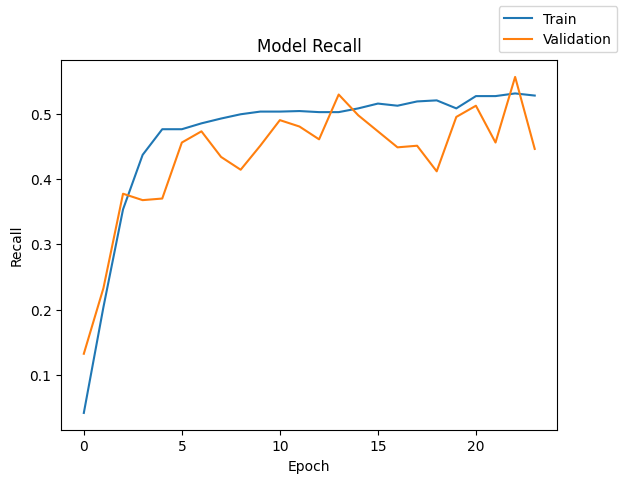

In [ ]:
plot(history_4,'recall')

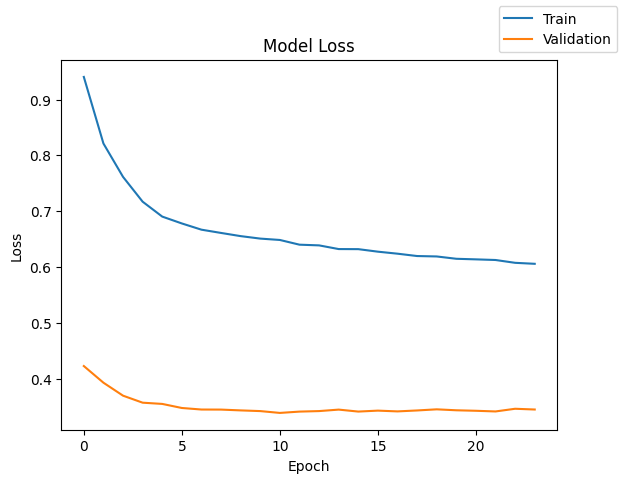

In [ ]:
plot(history_4,'loss')

In [ ]:
# Checking model's performance on training set
model_4_train_perf = model_performance_classification_binary(model_4, X_train, y_train)
model_4_train_perf

188/188 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.878,0.878,0.873,0.868


In [ ]:
model_4_valid_perf = model_performance_classification_binary(model_4, X_val, y_val)
model_4_valid_perf

63/63 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.847,0.847,0.834,0.834


- Train F1 score of ~0.73 and test F1 score of ~0.71 indicate consistent performance of the model between training and testing datasets.

- Even though it's a good score, the rate of improvement over the epochs is still low.

In [ ]:
# columns = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer ","# epochs","batch size","Optimizer", "SMOTE", "Dropout","Train_loss","Valid_loss","Train_Recall","Validation_Recall","time (secs)"]

results.loc[4] = [1,32,'Sigmoid',24,"64","Adam","Yes","No",history_4.history["loss"][-1],history_4.history["val_loss"][-1],history_4.history["recall"][-1],history_4.history["val_recall"][-1],round(end-start,2)]
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,Optimizer,SMOTE,Dropout,train loss,validation loss,train recall,validation recall,time (secs)
0,1,32,Sigmoid,24,64,SGD,No,No,1.224,0.595,0.683,0.694,21.570
1,1,32,Sigmoid,24,64,Adam,No,No,0.827,0.445,0.794,0.745,22.510
2,1,32,Sigmoid,24,64,Adam,No,Yes,0.950,0.456,0.755,0.745,8.810
3,1,32,Sigmoid,24,64,SGD,Yes,No,0.919,0.453,0.001,0.007,7.200
4,1,32,Sigmoid,24,64,Adam,Yes,No,0.606,0.345,0.528,0.446,9.020


### Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout

- Let's SMOTE to balance the data and use Adam Optimizer with Dropout
  - Using the Synthetic Minority Over-sampling Technique (SMOTE) for handling class imbalance
  - Dropout: Added after each hidden layer to help prevent overfitting.

In [ ]:
%%time
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of X_train: {}".format(X_train_over.shape))
print("After Oversampling, the shape of y_train: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 1222
Before Oversampling, counts of label 'No': 4778 

After Oversampling, counts of label 'Yes': 4778
After Oversampling, counts of label 'No': 4778 

After Oversampling, the shape of X_train: (9556, 16)
After Oversampling, the shape of y_train: (9556,) 

CPU times: user 64 ms, sys: 3.84 ms, total: 67.8 ms
Wall time: 57.3 ms


In [ ]:
# Recalculate class weights for imbalanced dataset and verify
cw = (y_train_over.shape[0]) / np.bincount(y_train_over)

# Create a dictionary mapping class indices to their respective class weights
cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[i] = cw[i]

cw_dict

{0: 2.0, 1: 2.0}

In [ ]:
# defining the batch size and # epochs upfront as we'll be using the same values for all models
epochs = 24
batch_size = 64

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [ ]:
#Initializing the neural network model
model_5 = Sequential()
# Adding input layer
model_5.add(Dense(64,activation="relu",input_dim=X_train.shape[1]))
model_5.add(Dropout(0.5))  # 50% Dropout rate
# Adding first hidden layer
model_5.add(Dense(32,activation="relu"))
model_5.add(Dropout(0.2))  # 20% Dropout rate
# Adding output layer
model_5.add(Dense(1,activation="sigmoid"))  # using sigmoid because target variable is binary class var

# Defining the Adam Optimizers
Adam = optimizers.Adam(learning_rate=1e-3)    # learning_rate = 0.001

metric = keras.metrics.Recall()
# metric = keras.metrics.F1Score()

In [ ]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compiling the model with categorical crossentropy as loss function with accuracy as metrics
model_5.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=Adam, metrics=[metric])

In [ ]:
start = time.time()
history_5 = model_5.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/24
94/94 [==============================] - 1s 5ms/step - loss: 1.0275 - recall: 0.0736 - val_loss: 0.4534 - val_recall: 0.0172
Epoch 2/24
94/94 [==============================] - 0s 3ms/step - loss: 0.9281 - recall: 0.0957 - val_loss: 0.4285 - val_recall: 0.0833
Epoch 3/24
94/94 [==============================] - 0s 3ms/step - loss: 0.8870 - recall: 0.1637 - val_loss: 0.4141 - val_recall: 0.1593
Epoch 4/24
94/94 [==============================] - 0s 3ms/step - loss: 0.8630 - recall: 0.2079 - val_loss: 0.4006 - val_recall: 0.1936
Epoch 5/24
94/94 [==============================] - 0s 3ms/step - loss: 0.8413 - recall: 0.2619 - val_loss: 0.3919 - val_recall: 0.2500
Epoch 6/24
94/94 [==============================] - 0s 4ms/step - loss: 0.8309 - recall: 0.2807 - val_loss: 0.3816 - val_recall: 0.3015
Epoch 7/24
94/94 [==============================] - 0s 4ms/step - loss: 0.8048 - recall: 0.3314 - val_loss: 0.3711 - val_recall: 0.3382
Epoch 8/24
94/94 [==============================

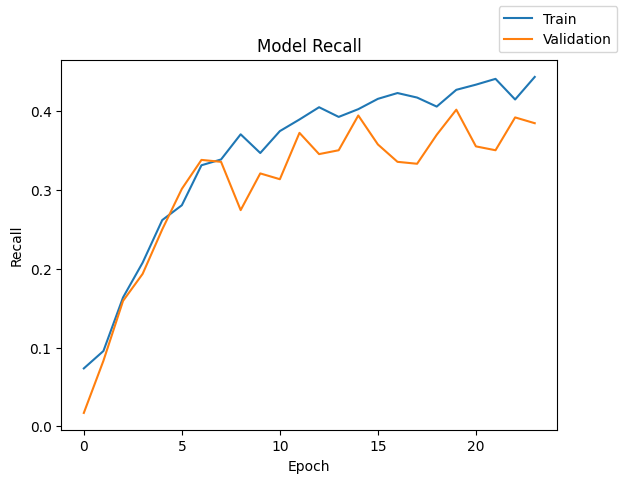

In [ ]:
plot(history_5,'recall')

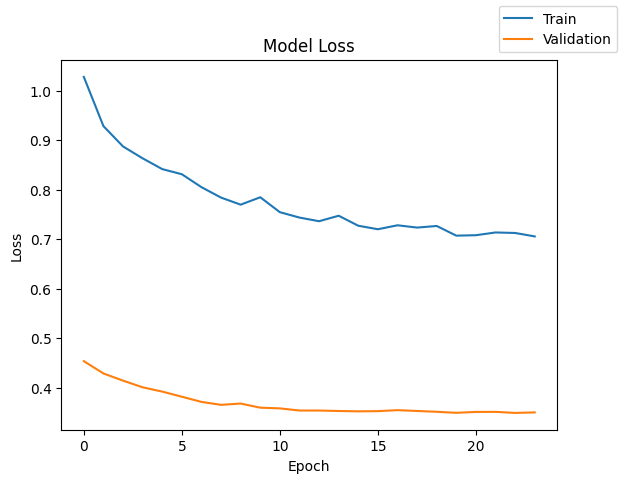

In [ ]:
plot(history_5,'loss')

In [ ]:
# Checking model's performance on training set
model_5_train_perf = model_performance_classification_binary(model_5, X_train, y_train)
model_5_train_perf

188/188 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.870,0.870,0.865,0.855


In [ ]:
model_5_valid_perf = model_performance_classification_binary(model_5, X_val, y_val)
model_5_valid_perf

63/63 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.846,0.846,0.833,0.826


- Train F1 score of ~0.73 and test F1 score of ~0.71 indicate consistent performance of the model between training and testing datasets.

- Even though it's a good score, the rate of improvement over the epochs is still low.

In [ ]:
# columns = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer ","# epochs","batch size","Optimizer", "SMOTE", "Dropout","Train_loss","Valid_loss","Train_Recall","Validation_Recall","time (secs)"]

results.loc[5] = [1,32,'Sigmoid',24,"64","Adam","Yes","Yes",history_5.history["loss"][-1],history_5.history["val_loss"][-1],history_5.history["recall"][-1],history_5.history["val_recall"][-1],round(end-start,2)]
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,Optimizer,SMOTE,Dropout,train loss,validation loss,train recall,validation recall,time (secs)
0,1,32,Sigmoid,24,64,SGD,No,No,1.224,0.595,0.683,0.694,21.570
1,1,32,Sigmoid,24,64,Adam,No,No,0.827,0.445,0.794,0.745,22.510
2,1,32,Sigmoid,24,64,Adam,No,Yes,0.950,0.456,0.755,0.745,8.810
3,1,32,Sigmoid,24,64,SGD,Yes,No,0.919,0.453,0.001,0.007,7.200
4,1,32,Sigmoid,24,64,Adam,Yes,No,0.606,0.345,0.528,0.446,9.020
5,1,32,Sigmoid,24,64,Adam,Yes,Yes,0.705,0.350,0.444,0.385,9.540


### Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, Dropout and He Initialization

- Let's SMOTE to balance the data and use Adam Optimizer with Dropout
  - Using the Synthetic Minority Over-sampling Technique (SMOTE) for handling class imbalance
- Dropout: Added after each hidden layer to help prevent overfitting.
- Use He Initialization




In [ ]:
%%time
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of X_train: {}".format(X_train_over.shape))
print("After Oversampling, the shape of y_train: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 1222
Before Oversampling, counts of label 'No': 4778 

After Oversampling, counts of label 'Yes': 4778
After Oversampling, counts of label 'No': 4778 

After Oversampling, the shape of X_train: (9556, 16)
After Oversampling, the shape of y_train: (9556,) 

CPU times: user 42.6 ms, sys: 5.94 ms, total: 48.6 ms
Wall time: 33.1 ms


In [ ]:
# Recalculate class weights for imbalanced dataset and verify
cw = (y_train_over.shape[0]) / np.bincount(y_train_over)

# Create a dictionary mapping class indices to their respective class weights
cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[i] = cw[i]

cw_dict

{0: 2.0, 1: 2.0}

In [ ]:
# defining the batch size and # epochs upfront as we'll be using the same values for all models
epochs = 24
batch_size = 64

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [ ]:
#Initializing the neural network model
model_6 = Sequential()
# Adding input layer
model_6.add(Dense(64,activation="relu",kernel_initializer="he_normal",input_dim=X_train.shape[1]))
model_6.add(Dropout(0.5))  # 50% Dropout rate
# Adding first hidden layer
model_6.add(Dense(32,activation="relu",kernel_initializer="he_normal",))
model_6.add(Dropout(0.2))  # 20% Dropout rate
# Adding output layer
model_6.add(Dense(1,activation="sigmoid",kernel_initializer="he_normal",))  # using sigmoid because target variable is binary class var

# Defining the Adam Optimizers
Adam = optimizers.Adam(learning_rate=1e-3)    # learning_rate = 0.001

metric = keras.metrics.Recall()
# metric = keras.metrics.F1Score()

In [ ]:
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compiling the model with categorical crossentropy as loss function with accuracy as metrics
model_6.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=Adam, metrics=[metric])

In [ ]:
start = time.time()
history_6 = model_6.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/24
94/94 [==============================] - 1s 5ms/step - loss: 1.1437 - recall: 0.0933 - val_loss: 0.4612 - val_recall: 0.0196
Epoch 2/24
94/94 [==============================] - 0s 3ms/step - loss: 0.9980 - recall: 0.0957 - val_loss: 0.4362 - val_recall: 0.0858
Epoch 3/24
94/94 [==============================] - 0s 3ms/step - loss: 0.9581 - recall: 0.1113 - val_loss: 0.4255 - val_recall: 0.1740
Epoch 4/24
94/94 [==============================] - 0s 3ms/step - loss: 0.9332 - recall: 0.1530 - val_loss: 0.4158 - val_recall: 0.1838
Epoch 5/24
94/94 [==============================] - 0s 3ms/step - loss: 0.9042 - recall: 0.1481 - val_loss: 0.4129 - val_recall: 0.2108
Epoch 6/24
94/94 [==============================] - 0s 3ms/step - loss: 0.8897 - recall: 0.2029 - val_loss: 0.4074 - val_recall: 0.2377
Epoch 7/24
94/94 [==============================] - 0s 3ms/step - loss: 0.8778 - recall: 0.2259 - val_loss: 0.4019 - val_recall: 0.2647
Epoch 8/24
94/94 [==============================

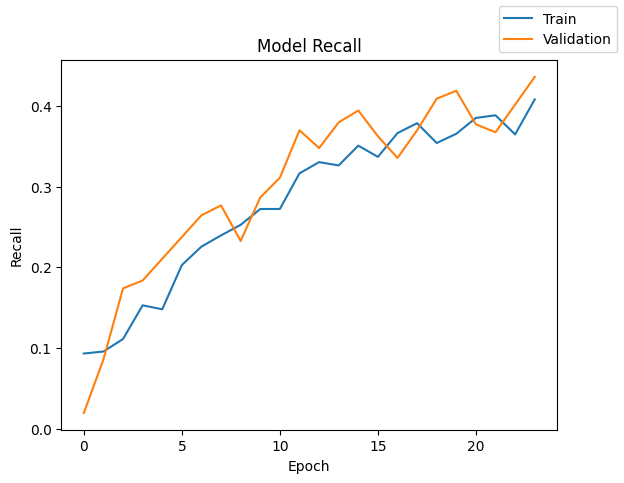

In [ ]:
plot(history_6,'recall')

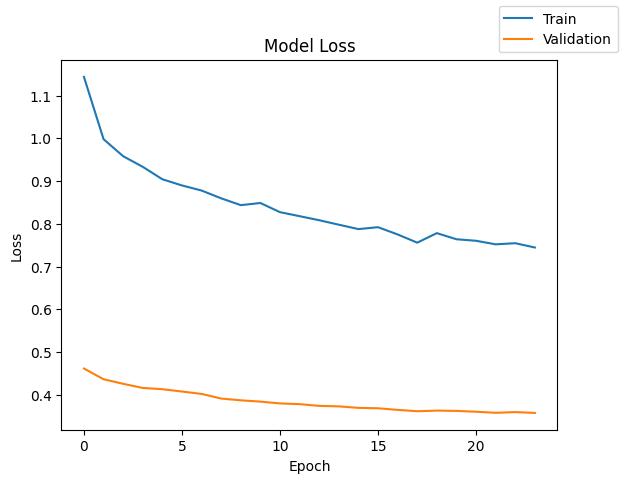

In [ ]:
plot(history_6,'loss')

In [ ]:
# Checking model's performance on training set
model_6_train_perf = model_performance_classification_binary(model_6, X_train, y_train)
model_6_train_perf

188/188 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.865,0.865,0.857,0.853


In [ ]:
model_6_valid_perf = model_performance_classification_binary(model_6, X_val, y_val)
model_6_valid_perf

63/63 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.848,0.848,0.835,0.834


- Train F1 score of ~0.73 and test F1 score of ~0.71 indicate consistent performance of the model between training and testing datasets.

- Even though it's a good score, the rate of improvement over the epochs is still low.

In [ ]:
# columns = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer ","# epochs","batch size","Optimizer", "SMOTE", "Dropout","Train_loss","Valid_loss","Train_Recall","Validation_Recall","time (secs)"]

results.loc[6] = [1,32,'Sigmoid',24,"64","Adam","Yes","Yes",history_6.history["loss"][-1],history_6.history["val_loss"][-1],history_6.history["recall"][-1],history_6.history["val_recall"][-1],round(end-start,2)]
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,Optimizer,SMOTE,Dropout,train loss,validation loss,train recall,validation recall,time (secs)
0,1,32,Sigmoid,24,64,SGD,No,No,1.224,0.595,0.683,0.694,21.570
1,1,32,Sigmoid,24,64,Adam,No,No,0.827,0.445,0.794,0.745,22.510
2,1,32,Sigmoid,24,64,Adam,No,Yes,0.950,0.456,0.755,0.745,8.810
3,1,32,Sigmoid,24,64,SGD,Yes,No,0.919,0.453,0.001,0.007,7.200
4,1,32,Sigmoid,24,64,Adam,Yes,No,0.606,0.345,0.528,0.446,9.020
5,1,32,Sigmoid,24,64,Adam,Yes,Yes,0.705,0.350,0.444,0.385,9.540
6,1,32,Sigmoid,24,64,Adam,Yes,Yes,0.744,0.357,0.408,0.436,9.510


## Model Performance Comparison and Final Model Selection

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_0_train_perf.T,
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
        model_5_train_perf.T,
        model_6_train_perf.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Neural Network with SGD Optimizer",
    "Neural Network with Adam Optimizer",
    "Neural Network with Adam Optimizer and Dropout",
    "Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer",
    "Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer",
    "Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout",
    "Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, Dropout and He Initialization"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Neural Network with SGD Optimizer,Neural Network with Adam Optimizer,Neural Network with Adam Optimizer and Dropout,Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer,Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer,"Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout","Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, Dropout and He Initialization"
Accuracy,0.702,0.817,0.798,0.797,0.878,0.870,0.865
Recall,0.702,0.817,0.798,0.797,0.878,0.870,0.865
Precision,0.790,0.858,0.841,0.838,0.873,0.865,0.857
F1 Score,0.728,0.829,0.811,0.707,0.868,0.855,0.853


In [ ]:
# Validation performance comparison

models_validation_comp_df = pd.concat(
    [
        model_0_valid_perf.T,
        model_1_valid_perf.T,
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T,
        model_5_valid_perf.T,
        model_6_valid_perf.T
    ],
    axis=1,
)
models_validation_comp_df.columns = [
    "Neural Network with SGD Optimizer",
    "Neural Network with Adam Optimizer",
    "Neural Network with Adam Optimizer and Dropout",
    "Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer",
    "Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer",
    "Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout",
    "Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, Dropout and He Initialization"
]
print("Validation performance comparison:")
models_validation_comp_df

Validation performance comparison:


,Neural Network with SGD Optimizer,Neural Network with Adam Optimizer,Neural Network with Adam Optimizer and Dropout,Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer,Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer,"Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout","Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, Dropout and He Initialization"
Accuracy,0.697,0.796,0.792,0.797,0.847,0.846,0.848
Recall,0.697,0.796,0.792,0.797,0.847,0.846,0.848
Precision,0.791,0.839,0.837,0.839,0.834,0.833,0.835
F1 Score,0.724,0.810,0.806,0.709,0.834,0.826,0.834


In [ ]:
models_train_comp_df-models_validation_comp_df

,Neural Network with SGD Optimizer,Neural Network with Adam Optimizer,Neural Network with Adam Optimizer and Dropout,Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer,Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer,"Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout","Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, Dropout and He Initialization"
Accuracy,0.005,0.020,0.006,-0.001,0.031,0.024,0.017
Recall,0.005,0.020,0.006,-0.001,0.031,0.024,0.017
Precision,-0.001,0.019,0.004,-0.001,0.039,0.032,0.021
F1 Score,0.004,0.019,0.005,-0.002,0.034,0.029,0.020


* Best result provided by this model: Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer. Provide ~83% F1 Score.
* 2nd best performing model is Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, Dropout and He Initialization



In [ ]:
# Let's check score on test data using best model
model_4_test_perf = model_performance_classification_binary(model_4, X_test, y_test)
model_4_test_perf

63/63 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.863,0.863,0.854,0.849


Best performing model is giving F1 score of ~84% on test data

In [ ]:
# Let's check score on test data using 2nd best model
model_6_test_perf = model_performance_classification_binary(model_6, X_test, y_test)
model_6_test_perf

63/63 [==============================] - 0s 1ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.849,0.849,0.837,0.833


### Confusion Matrix for Final Model

63/63 [==============================] - 0s 1ms/step


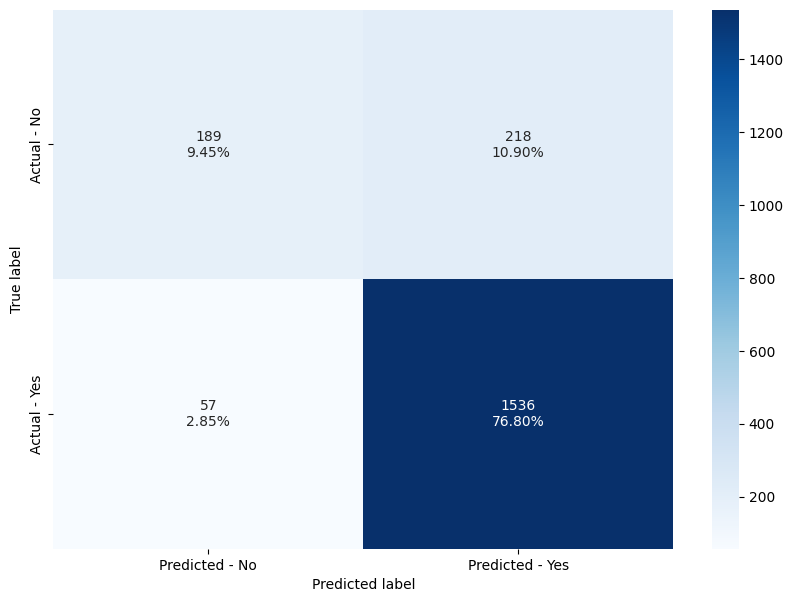

In [ ]:
display_confusion_matrix(model_4, X_test, y_test)

## Actionable Insights and Business Recommendations

* ~ 20% customers exited from Bank's service. Do not know the time frame of this data but that would helpful to find when these customers left and compare the relationship account opening and activities in credit card usage.
* 2037 customers left the bank. Out of 2037, 1424 customers had a credit card who have exited the bank. So credit card type of account holder has high chance of churn and so bank should do additional analysis in credit card churn and take some measurement to prevent this type of churn.
* Customer's Age factor does show influence with who left the bank. 50% customers who left the bank are from age group  of 36 to 50. Bank can run some promotional campains for customers who are older than 35 to prevent churn.
* Customers has been with the bank on avg 5yrs and the Bank can take advantage of long term relationship by offering more products and service to their loyal customers.
* Germancy customers has very chances of churn. 814 customers from Germany who have exited. 577 customers with credit card and from Germany, who have exited. 2 out 3 Germancy customer left the bank. Bank seriously needs to look in service provided to Germany based customers. Consider strategic initiative to improve service as well as find out customer's dissatisfaction.
* 75% customers who left the bank had credit card. So recommend the bank to keep an eye on customers who has credit card than other types of account with the bank to prevent the churn. Run some promotional campains to credit card customers to keep them engaged with credit card as well try to cross sell other product services.
* A lot of Bank's customers has lower credit score and bank offer some financial support and services e.g. offer personal loan to build stronger relationship with that customer base.
* Customer who has balance of 40K to 125K has higher chances of churn.
Suggest to bank to run some campain for customers who has 50K or higher balance and try to increase customer satisfaction.
* Bank has a lot of senior citizen customers. Bank can offer them more retirement benefits related services to keep them engaged.
* 70% customers have Bank's credit card and can promote more rewards services and also consider promotional campains.
* 418 customers who had no credit card but had a different type product service and still they left the bank. This needs further data and analysis what type of product service these 418 customer had.
* With NN Model built, we are able to predict 77% customer will churn with 84% of F1 Score.




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



## Exploratory Data Analysis (EDA)

### Data Preprocessing
1. Check for Missing value treatment
2. Check for Feature engineering (if needed)
3. Outlier detection and treatment (if needed)

In [ ]:
data = originalData.copy()

### Missing Value Treatment

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
# Check in null values
data.isnull().sum()     # use data.isna().sum() its gives missing values

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### Observation
Looks like Education_Level and Marital Status columns has missing values

### Let's drop the few columns that wont add value in EDA

In [ ]:
## drop the columns from the dataframe
data = data.drop('RowNumber', axis=1)
data = data.drop('CustomerId', axis=1)
data = data.drop('Surname', axis=1)

In [ ]:
# Check data without ID
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


In [ ]:
## Converting the data type of categorical features to 'category'
cat_cols = [
    "Gender",
    "Geography",
    "HasCrCard",
    "IsActiveMember",
    # "Surname",
    "Exited"    # Target variable
]
data[cat_cols] = data[cat_cols].astype("category")    # Code to convert the cat_cols to category

**Let's check the count and percentage of categorical levels in each column**

In [ ]:
# Printing the count of unique categorical levels in each column
for column in cat_cols:
    print(data[column].value_counts())
    print("-" * 50)

Gender
Male      5457
Female    4543
Name: count, dtype: int64
--------------------------------------------------
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
--------------------------------------------------
HasCrCard
1    7055
0    2945
Name: count, dtype: int64
--------------------------------------------------
IsActiveMember
1    5151
0    4849
Name: count, dtype: int64
--------------------------------------------------
Exited
0    7963
1    2037
Name: count, dtype: int64
--------------------------------------------------


#### Rename Attrition_Flag column as Target column

Encoding 'Existing Customer' and 'Attrited Customer' to 0 and 1 respectively, for analysis.


In [ ]:
data = data.rename(columns={'Exited': 'target'})

In [ ]:
data.target.value_counts()

target
0    7963
1    2037
Name: count, dtype: int64

EDA is an important part of any project involving data, it is critical to investigate and understand the data better before building a model with it.


### **Univariate Analysis**

Explore all the variables and provide observations on their distributions. (Generally, histograms, boxplots, countplots, etc. are used for univariate exploration.)

### Let's analyze numerical columns.

#### Observations on CreditScore

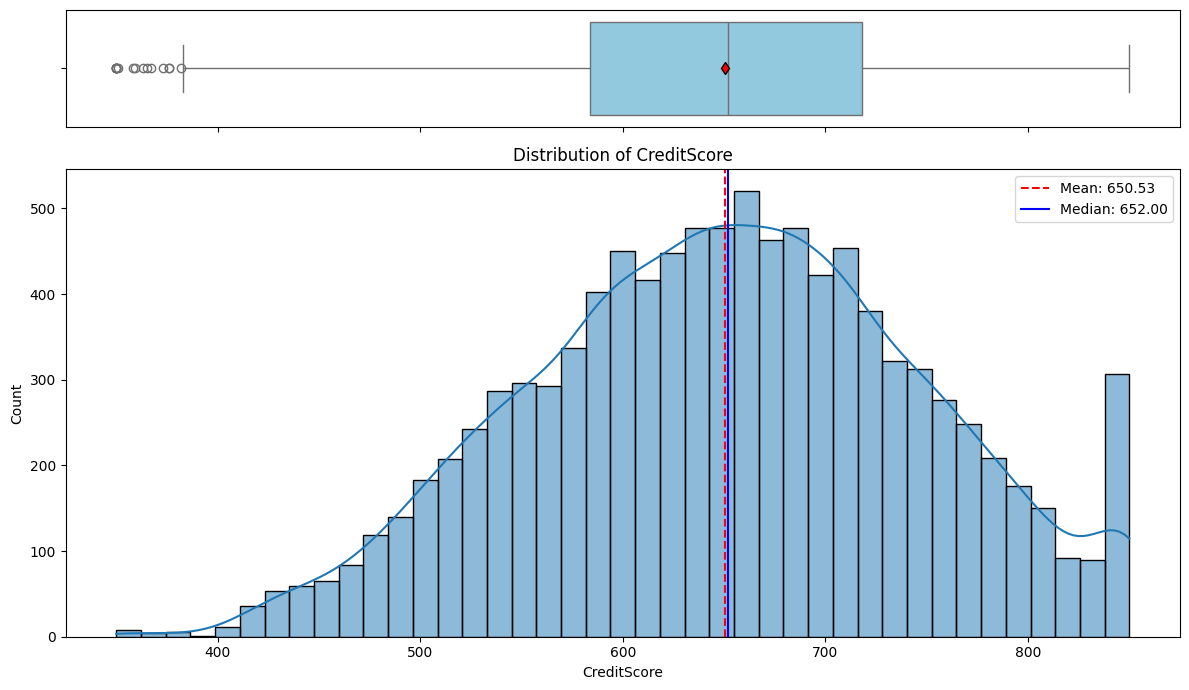

In [ ]:
histogram_boxplot(data, 'CreditScore');

In [ ]:
data.CreditScore.value_counts()

CreditScore
850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: count, Length: 460, dtype: int64

Observation:
* Credit Score data looks like normally distributed.
* Avg around 650
* Few outliers with very low score.
* Approx 233 customers has Max score of 850
* Suggest to cross sell more services to customers with these 850 scores
* Monitor customers who has very score
* Cross sell more product services

Let's try to categorize the customers based on their level of credit score

In [ ]:
# Define bins and labels
bins = [0, 580, 670, 740, 800, 850]
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']

# Create a new column with the binned categories
data['CreditScoreRating'] = pd.cut(data['CreditScore'], bins=bins, labels=labels, right=True)


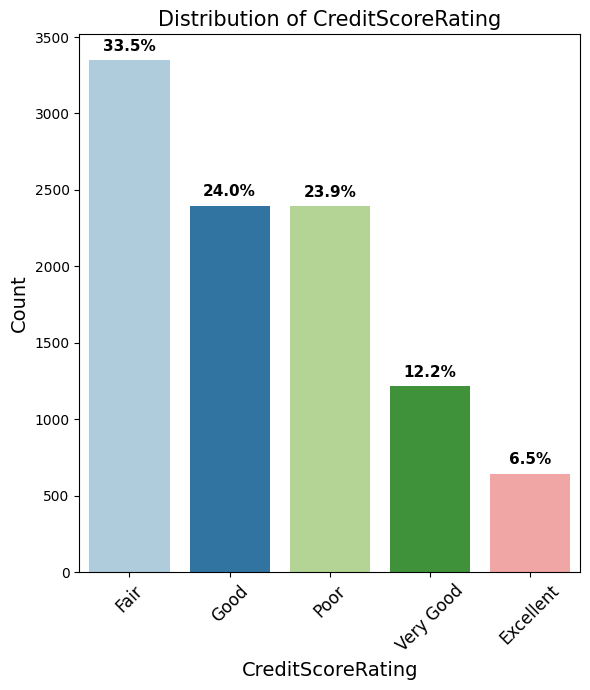

In [ ]:
labeled_barplot(data, "CreditScoreRating", perc=True)

In [ ]:
data.CreditScoreRating.value_counts()

CreditScoreRating
Fair         3350
Good         2397
Poor         2393
Very Good    1215
Excellent     645
Name: count, dtype: int64

Observation:
* Appears bank has majority of customers with Poor to Good credit scores
* Bank can consider to provide some financial support by offering personal loans to retain these customers. Can consider to build model to check if those customers will default on their loan or not to support this strategy


#### Observations on Age

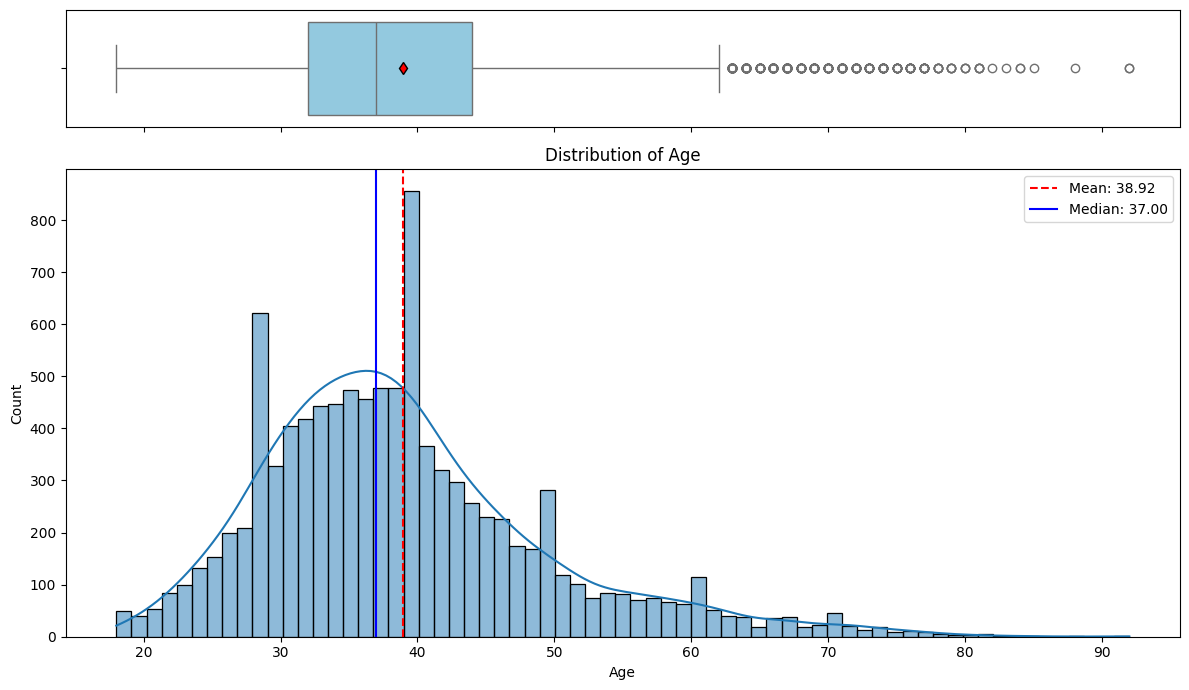

In [ ]:
histogram_boxplot(data, 'Age')

Observation:
* Age data looks like normally distributed but with a lot of outliers
* Avg around 39yrs but most of customers are between 25 to 60
* Many customers are senior citizens and so the data is right skewed


#### Observations on Tenure

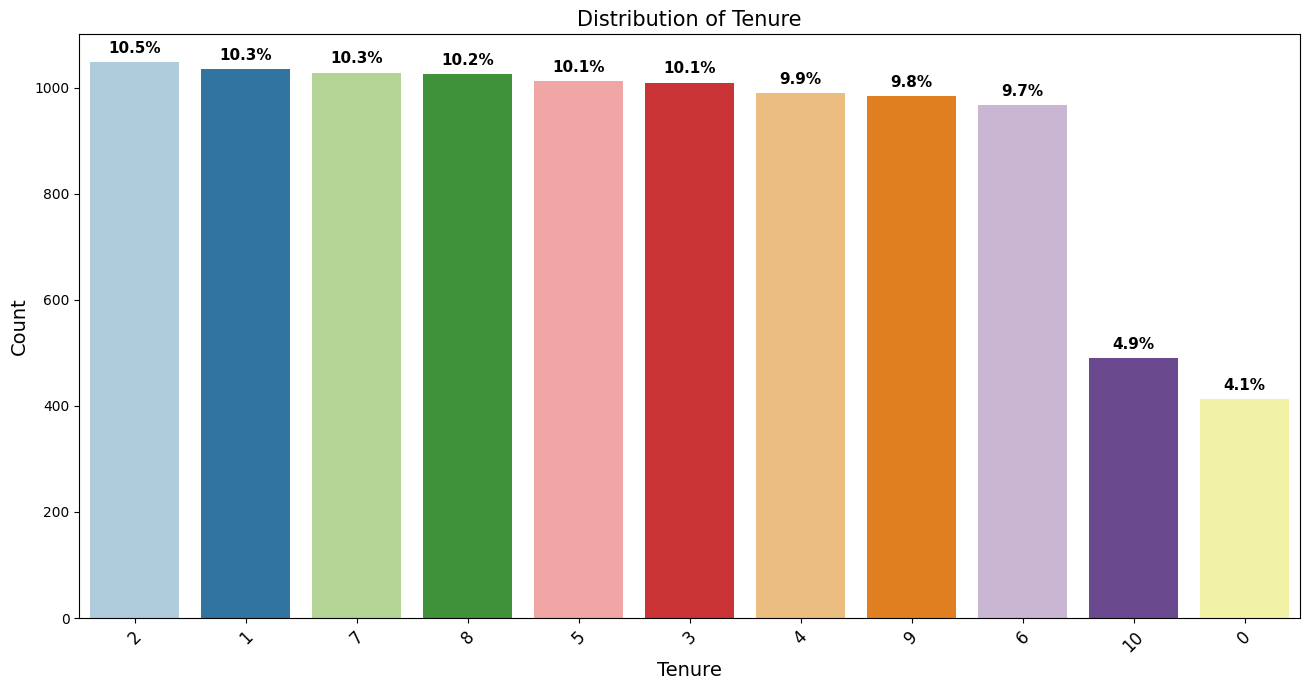

In [ ]:
labeled_barplot(data, "Tenure", perc=True)

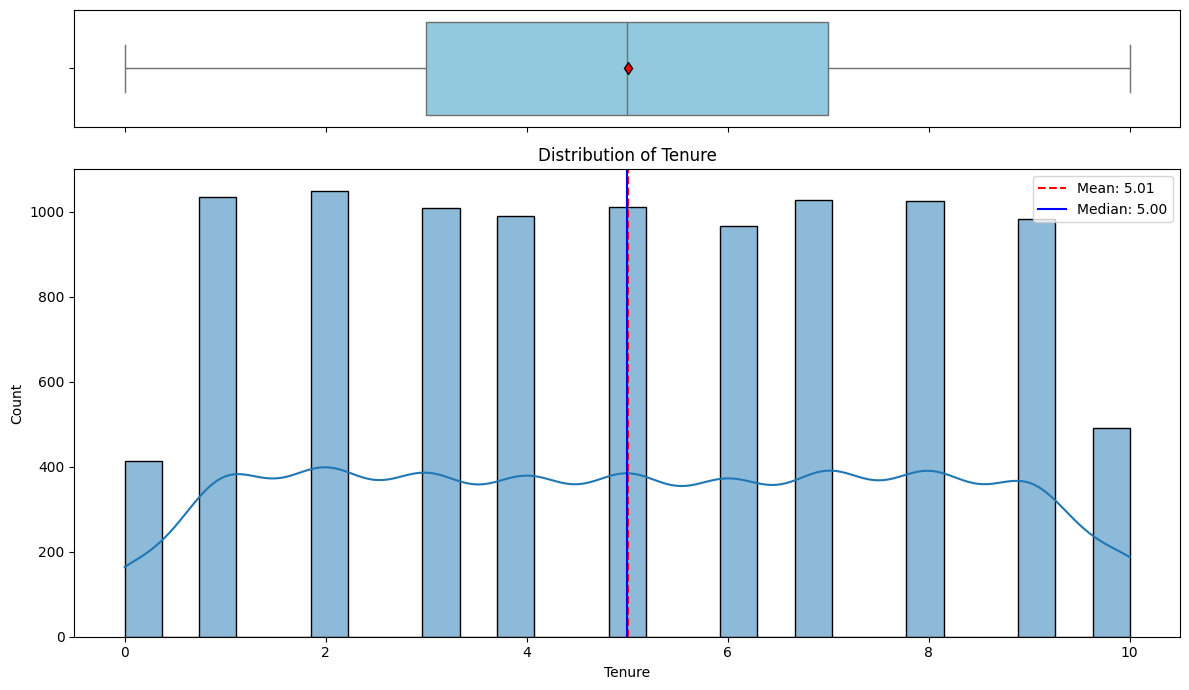

In [ ]:
histogram_boxplot(data, 'Tenure')

In [ ]:
data['Tenure'].value_counts()

Tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64

Observation
* Looks uniform distribution
* Avg customers has been with 5+ years with bank.

#### Observations on Balance

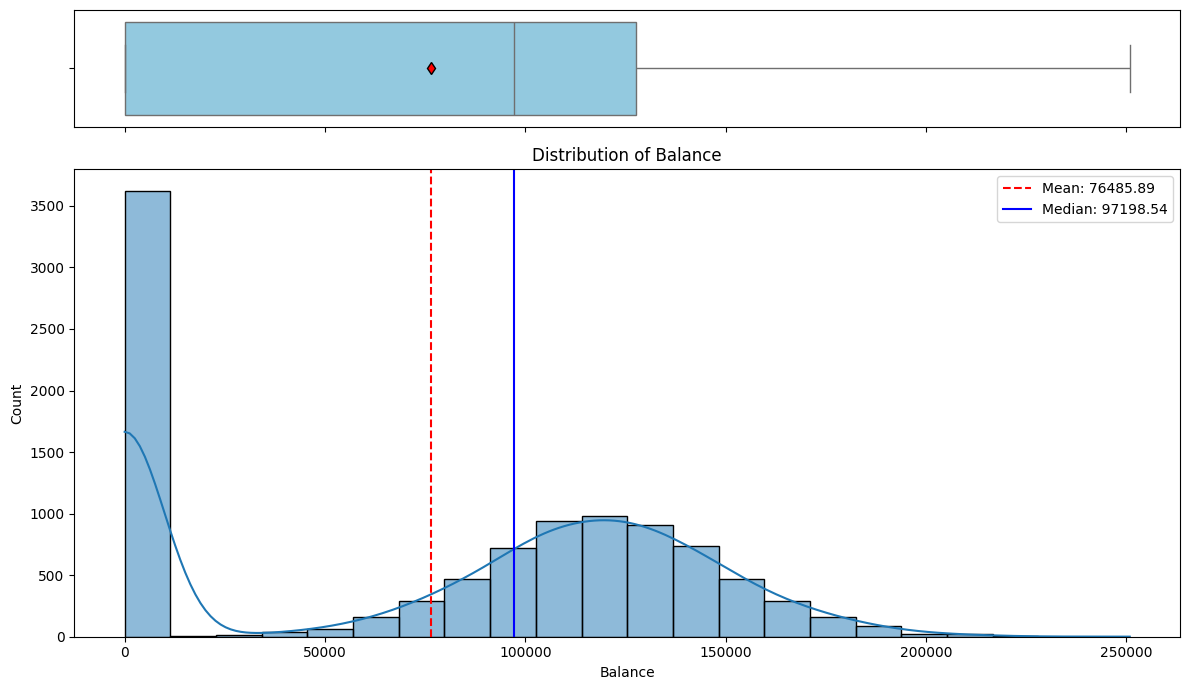

In [ ]:
histogram_boxplot(data, "Balance")

In [ ]:
# get customer count which have zero balance
data['ZeroBalance'] = np.where(data['Balance'] == 0, 1, 0)  # 'ZeroBalance' = 1 if 'Balance' is 0, otherwise 0

data.ZeroBalance.value_counts()

ZeroBalance
0    6383
1    3617
Name: count, dtype: int64

Observation
* 3617 Customers have zero balance with bank.
* What kind of balance is this? Is it saving or checking account balance?

#### Observations on NumOfProducts



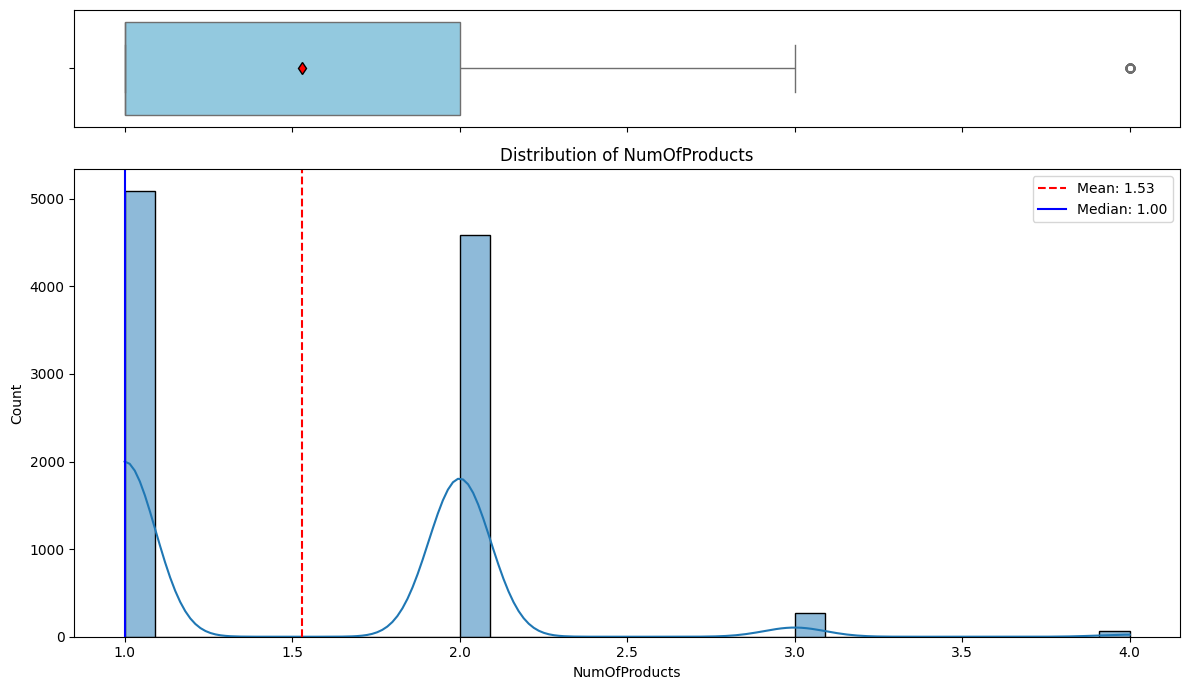

In [ ]:
histogram_boxplot(data, 'NumOfProducts')

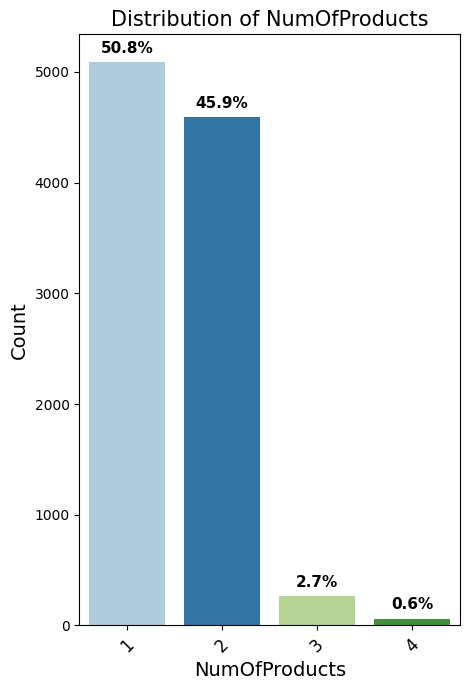

In [ ]:
labeled_barplot(data, "NumOfProducts", perc=True)

Obversation:
* 50% customers has more than one type of account/services with bank
* Avg is 1.5


#### Observations on EstimatedSalary

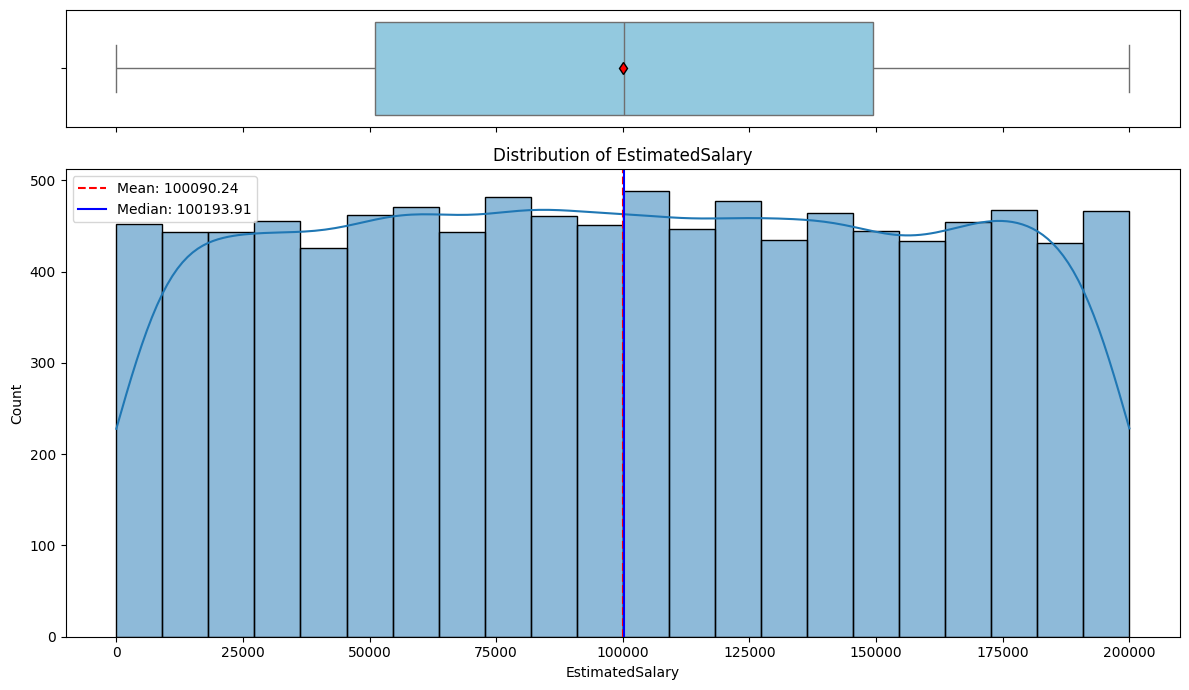

In [ ]:
histogram_boxplot(data, 'EstimatedSalary')

Obversation:
* Uniform distribution
* Avg estimated salary is 100000

### Let's analyze categorical columns.

#### Observation on Exited (target variable)

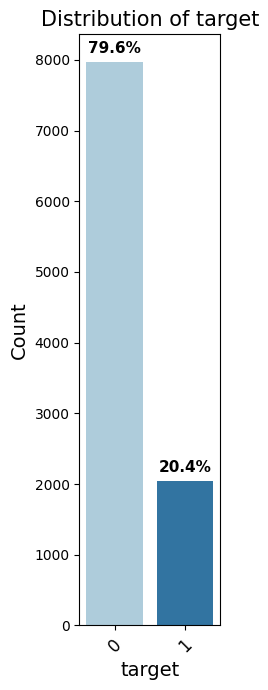

In [ ]:
labeled_barplot(data, 'target', perc=True)

In [ ]:
data.target.value_counts()

target
0    7963
1    2037
Name: count, dtype: int64

Observation
* ~ 20% of customers have left the bank
* Unbalanced data.

#### Observations on Gender

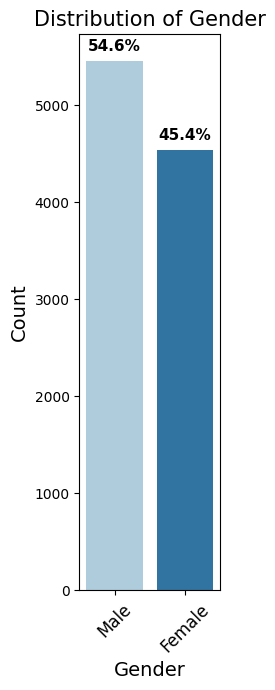

In [ ]:
labeled_barplot(data, 'Gender', perc=True)

Observation
* Normal distribution. Slightly higher Male customers than Female customers

#### Observations on Geography

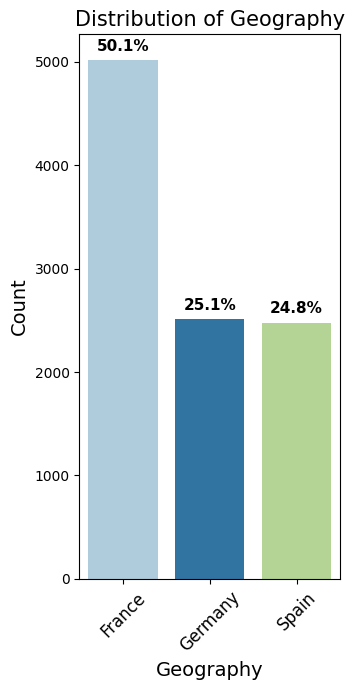

In [ ]:
labeled_barplot(data, 'Geography', perc=True)

Observation
* 50% customers are from France. Rest 50 customers are from Germany and Spain
* May be bank's home base aka head quarter is in France

#### Observation on HasCrCard

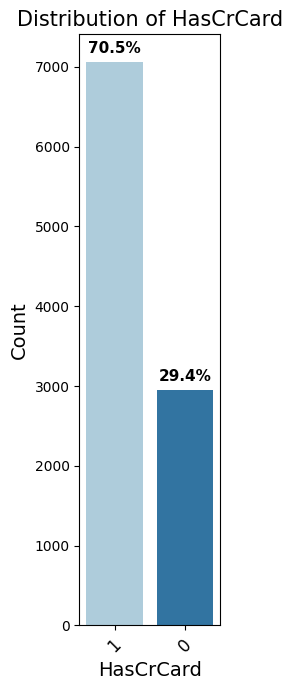

In [ ]:
labeled_barplot(data, 'HasCrCard', perc=True)

Observation
* 70% customers have credit card with bank
* Need to look in to other 30% customers, what kind of service they were taking from bank.

#### Observations on IsActiveMember

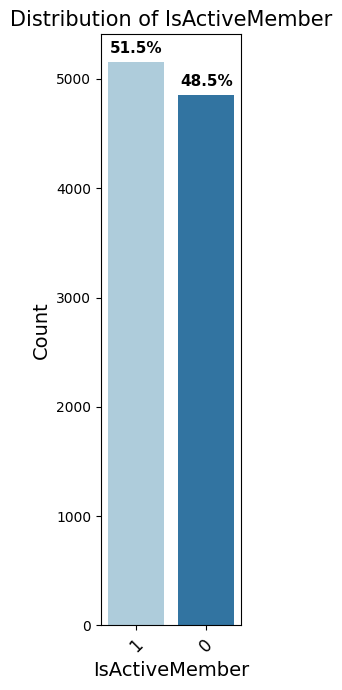

In [ ]:
labeled_barplot(data, 'IsActiveMember', perc=True)

In [ ]:
data.IsActiveMember.value_counts()

IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

Observation
* Normal distribution
* 50% customers are inactive.
* Need to check if these are credit card account holder

#### Observations on Surname

In [ ]:
# labeled_barplot(data, 'Surname', perc=True)

Observation
* Surname data alone do not provide any valuable insight

### **Multivariate Analysis**

### Perform a multivariate analysis to explore relationships between the important variables in the dataset. (It is a good idea to explore relations between numerical variables as well as relations between numerical and categorical variables)


### Correlation check

In [ ]:
# originalData.info()

In [ ]:
numeric_data = originalData.select_dtypes(include=['number'])

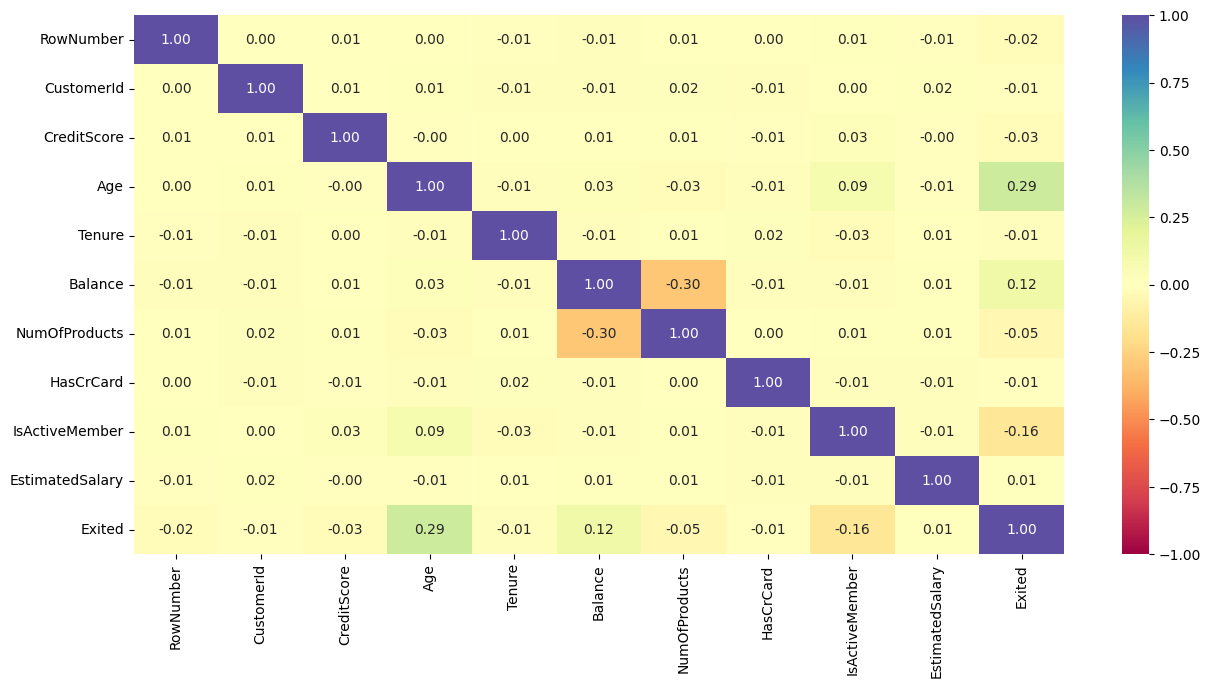

CPU times: user 1.05 s, sys: 119 ms, total: 1.17 s
Wall time: 1.11 s


In [ ]:
%%time
# Heatmap of the pre-processed data
plt.figure(figsize=(15, 7))
sns.heatmap(numeric_data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Observations
* None of the attributes has strong correlation with target variable
* Slight positive correlation between Age and Balance and customer exiting the bank.
* Slight negative correlation between isActiveMember and customer churned.




### Reverse Mapping for Encoded Variables

In [ ]:
## Function to inverse the encoding
def inverse_mapping(x, y):
    inv_dict = {v: k for k, v in x.items()}
    data[y] = data[y].map(inv_dict).astype("category")


### Pair Plot


In [ ]:
data.shape

(10000, 13)

CPU times: user 9.62 s, sys: 788 ms, total: 10.4 s
Wall time: 11.2 s


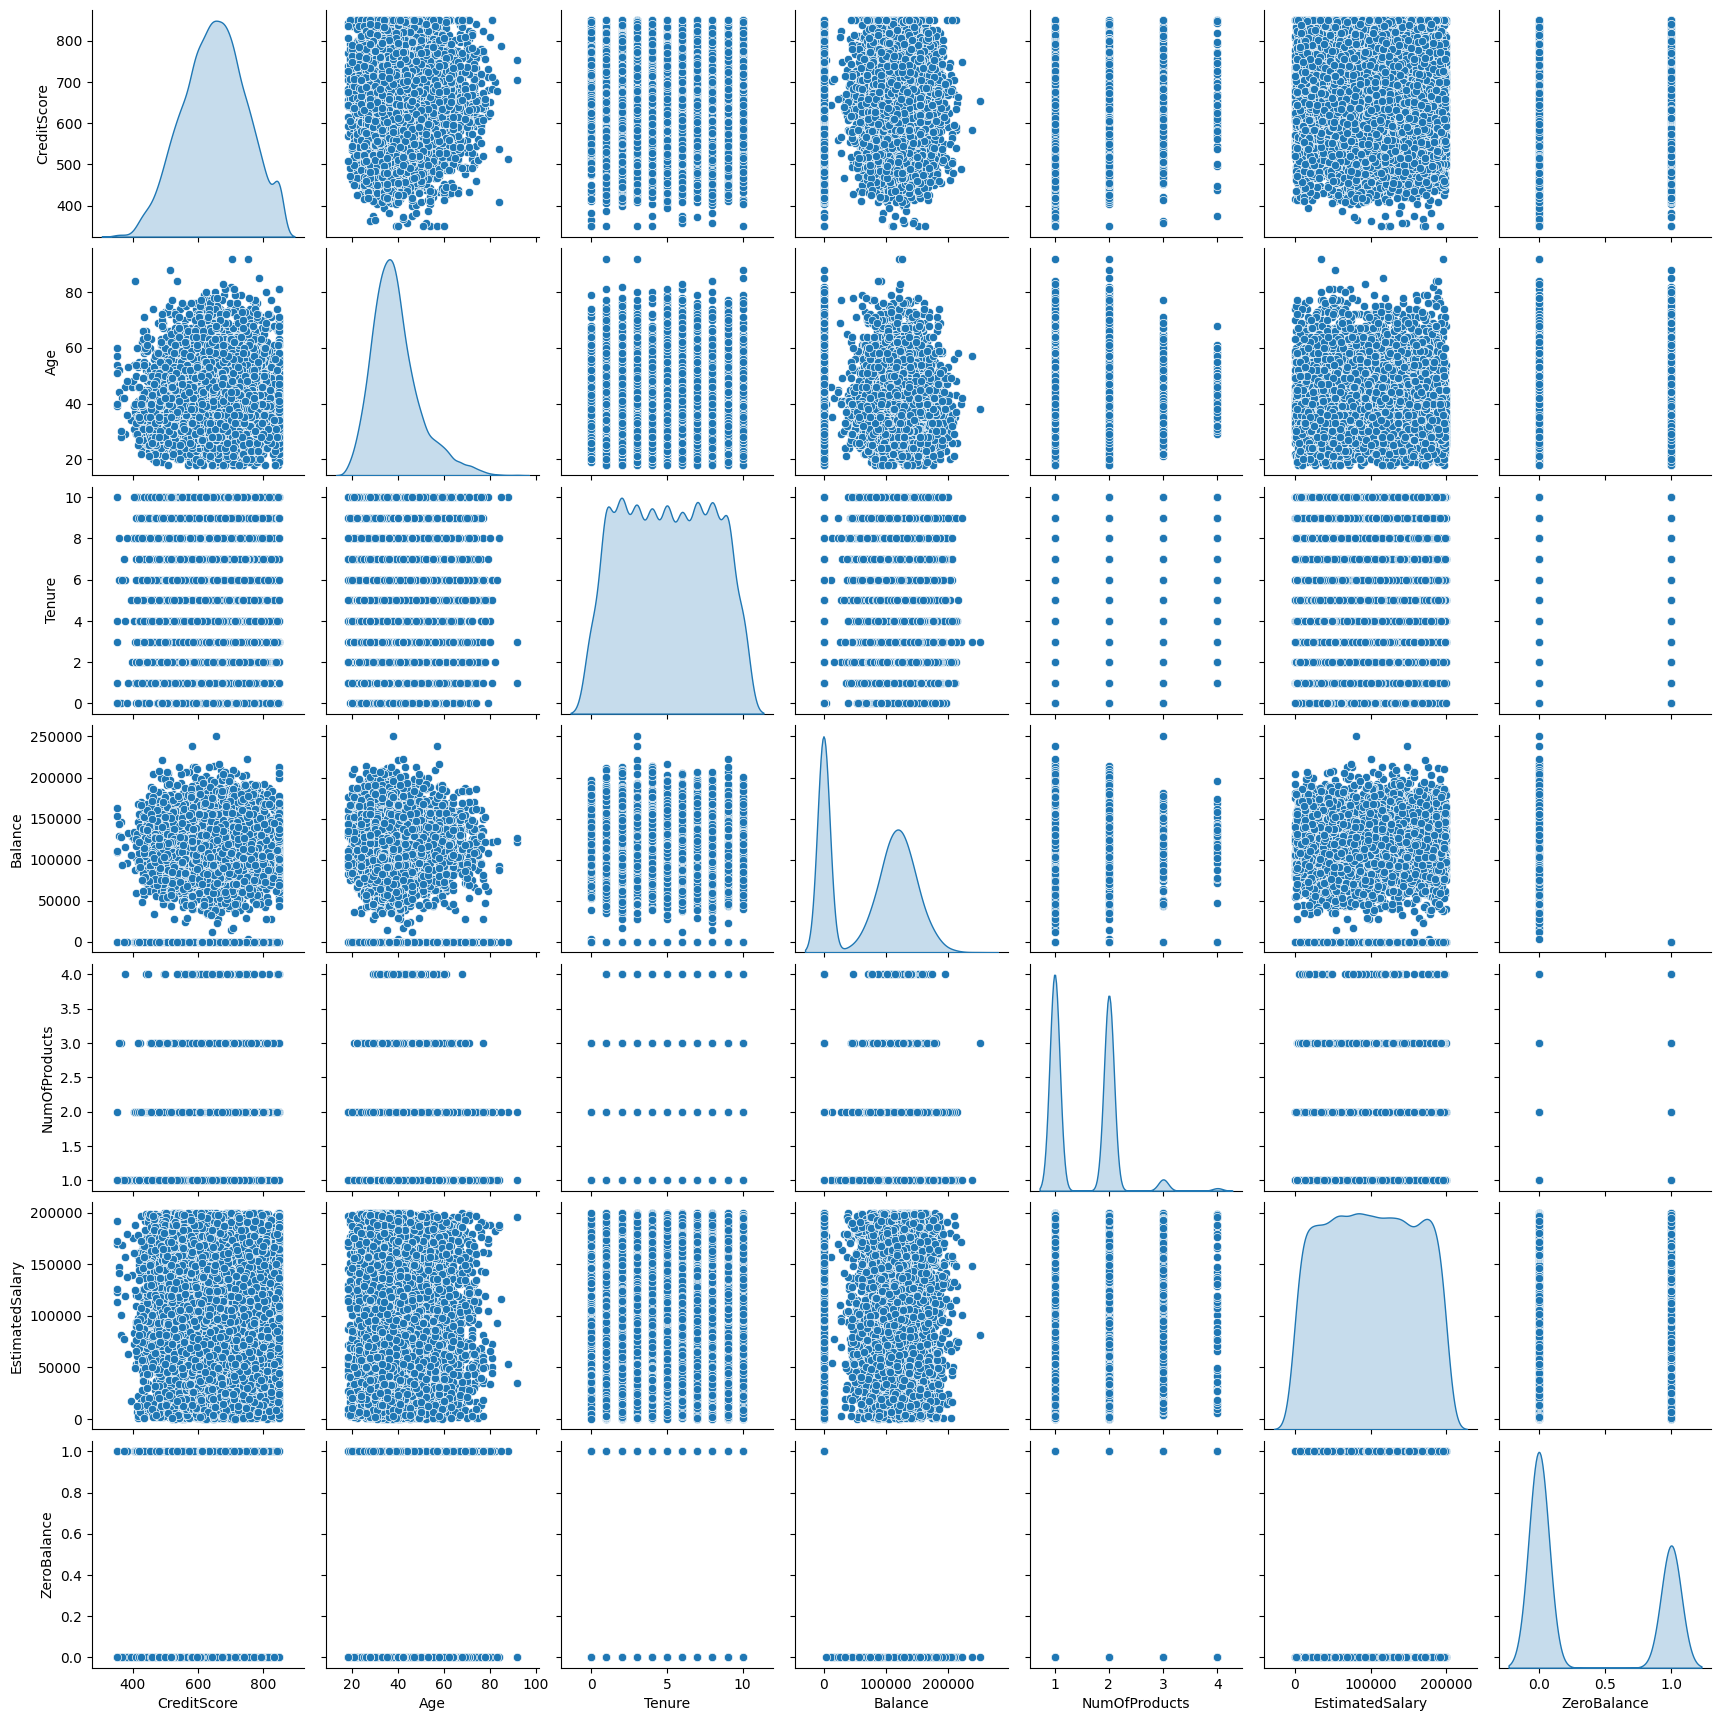

In [ ]:
%%time
data_attr = data.iloc[:, 0:14]
sns.pairplot(data_attr, diag_kind='kde');   # to plot density curve instead of histogram on the diag

Observation
* Pairplot do not show any significant relation between the numeric attributes

### Bivariate Analysis

A bivariate analysis among the different variables can be done using scatter matrix plot. Seaborn libs create a dashboard reflecting useful information about the dimensions.

**We'll focus on relation between Attrition Flag (Target variable) and rest of the attributes**

#### Target vs Age
Let's check how a customer's interest in purchasing a loan varies with their age

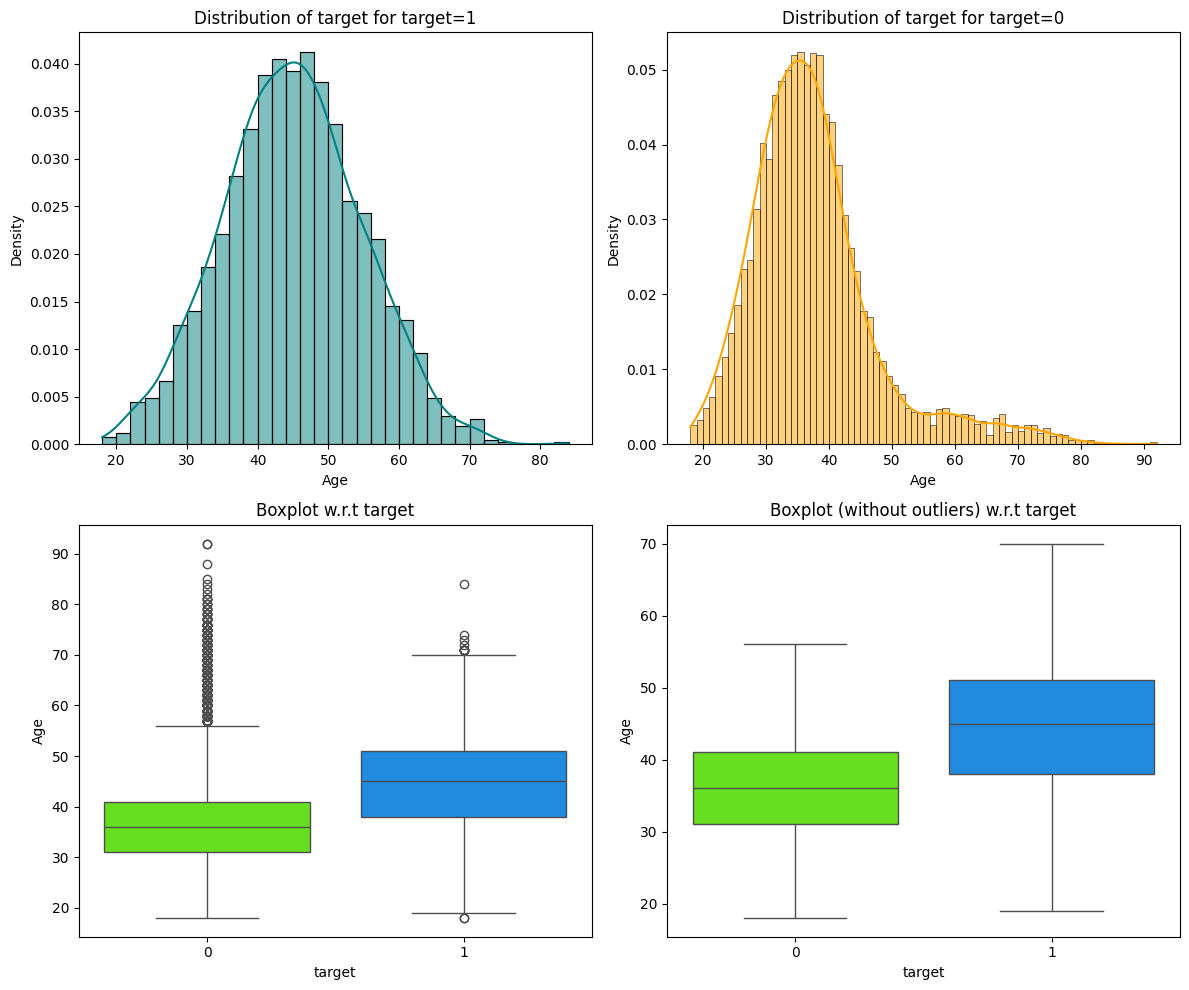

In [ ]:
distribution_plot_wrt_target(data, "Age", "target")

Observation
* Avg Customer's Age who left the bank is higher compared who are still with the bank. Avg around 45yrs.
* 50% customers who left the bank are from age group  of 36 to 50.
* A lot senior citizens are still loyal with bank. Bank can take advantage of this customer base.
* Bank can run some promotional campains for customers who are older than 35 to prevent churn.

#### Target vs Gender

In [ ]:
data.Gender.value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

Gender  Female  Male    All
target                     
All       4543  5457  10000
0         3404  4559   7963
1         1139   898   2037
------------------------------------------------------------------------------------------------------------------------


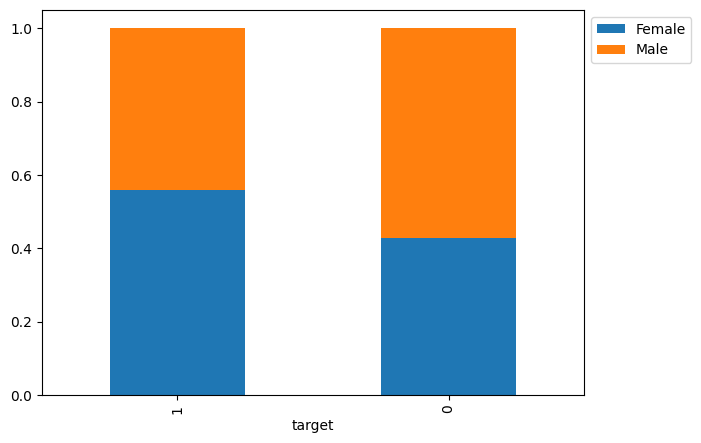

In [ ]:
stacked_barplot(data, 'target', 'Gender')

Observation
* Female customers has more chances in churn.
* ~60% of customers who exited the bank are Female customers.

#### Target vs Geography

Geography  France  Germany  Spain    All
target                                  
All          5014     2509   2477  10000
0            4204     1695   2064   7963
1             810      814    413   2037
------------------------------------------------------------------------------------------------------------------------


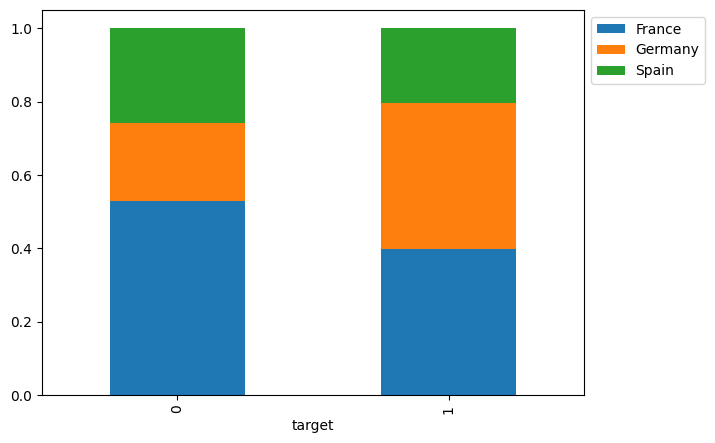

In [ ]:
stacked_barplot(data, 'target', 'Geography')

Observation
* Looks like Geography plays some role in chrun.
* Germany customers have very chances of churn. 2 out 3 Germany customer left the bank.
* Bank seriously needs to look in service provided to Germany based customers. Consider strategic initiatives to improve service as well as find out customer's dissatisfaction.
* Majority of customers who left the bank are from either Germany or France.

#### Target vs Tenure

Tenure    0     1     2     3    4     5    6     7     8    9   10    All
target                                                                    
All     413  1035  1048  1009  989  1012  967  1028  1025  984  490  10000
0       318   803   847   796  786   803  771   851   828  771  389   7963
1        95   232   201   213  203   209  196   177   197  213  101   2037
------------------------------------------------------------------------------------------------------------------------


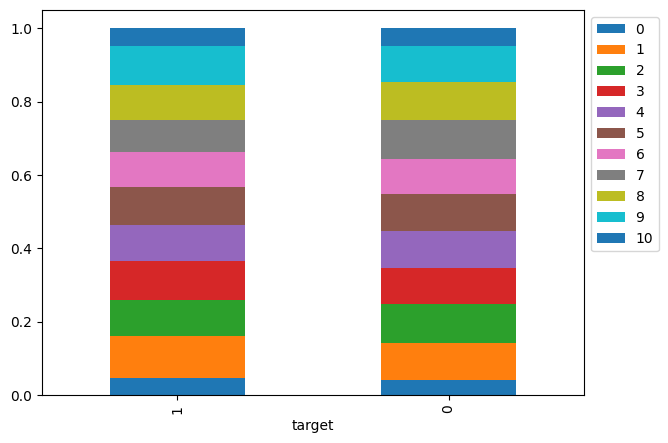

In [ ]:
stacked_barplot(data, 'target', 'Tenure')

Observation
* It does not look like Tenure makes much impact on chrun.
* Almost same distribution of tenure between customers who left the bank and customer who are with the bank.

#### Target vs HasCrCard

HasCrCard     0     1    All
target                      
All        2945  7055  10000
0          2332  5631   7963
1           613  1424   2037
------------------------------------------------------------------------------------------------------------------------


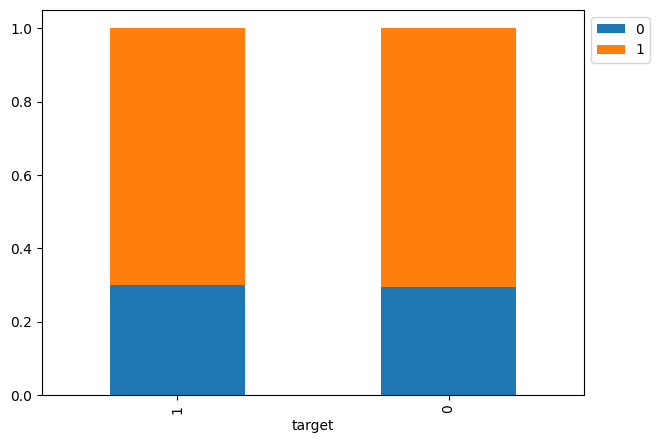

In [ ]:
stacked_barplot(data, 'target', 'HasCrCard')

Observation
* It does not look like Credit Card makes much impact on chrun.
* Almost same distribution between customers who left the bank and customer who are with the bank.
* However 75% customers who left the bank had credit card. So recommend the bank to keep an eye on customers who has credit card than other types of account with the bank to prevent the churn. Run some promotional campains to credit card customers to keep them engaged with credit card as well try to cross sell other product services.

#### Target vs IsActiveMember

IsActiveMember     0     1    All
target                           
All             4849  5151  10000
0               3547  4416   7963
1               1302   735   2037
------------------------------------------------------------------------------------------------------------------------


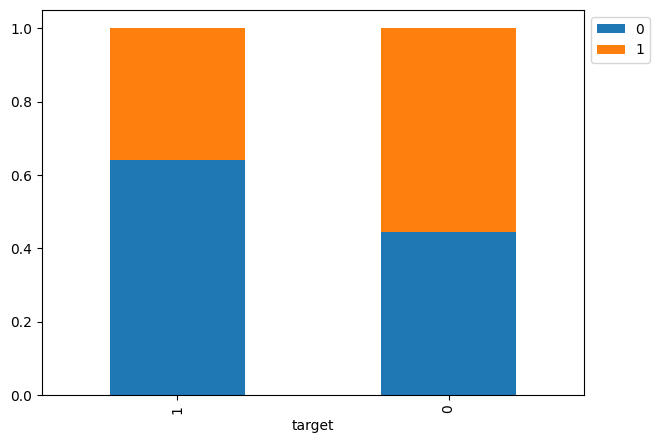

In [ ]:
stacked_barplot(data, 'target', 'IsActiveMember')

Observation
* Data indicate inactive customers has higher chances of churn.
* %65 of customers who left the bank were inactive with bank.
* Customer who are active has higher chance to stay with bank.

#### Target vs CreditScore

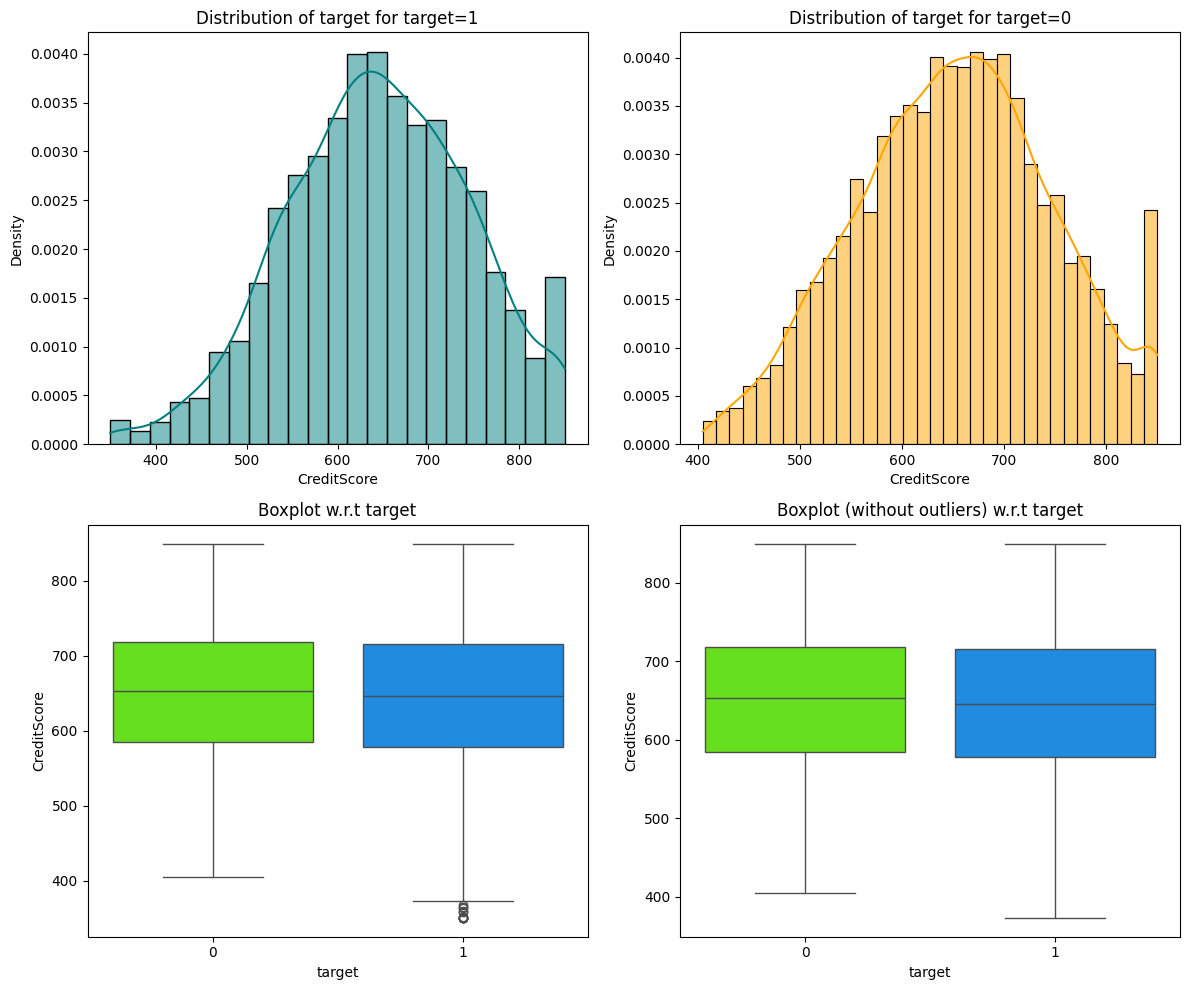

In [ ]:
distribution_plot_wrt_target(data, "CreditScore", "target")

Observation
* Credit Score do not have much impact on churn.
* Same distribution across both types of customers.

#### Target vs CreditScoreRating

CreditScoreRating  Poor  Fair  Good  Very Good  Excellent    All
target                                                          
All                2393  3350  2397       1215        645  10000
0                  1863  2667  1946        969        518   7963
1                   530   683   451        246        127   2037
------------------------------------------------------------------------------------------------------------------------


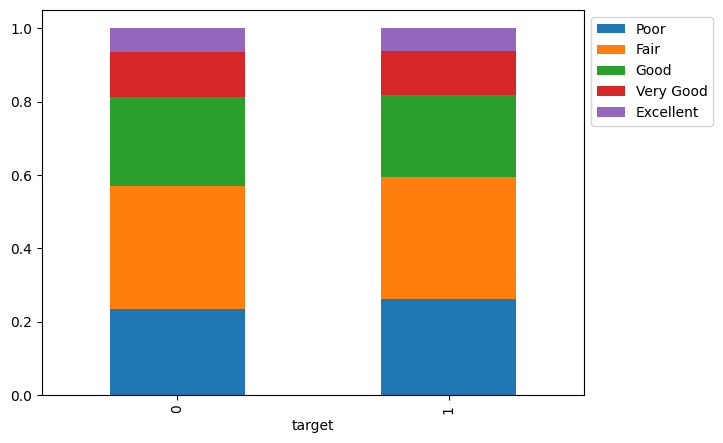

In [ ]:
stacked_barplot(data, 'target', 'CreditScoreRating')

Observation
* Credit Score Rating do not have much impact on churn.
* Customer who has poor or faire credit score has higher chance of churn.

#### Target vs Balance

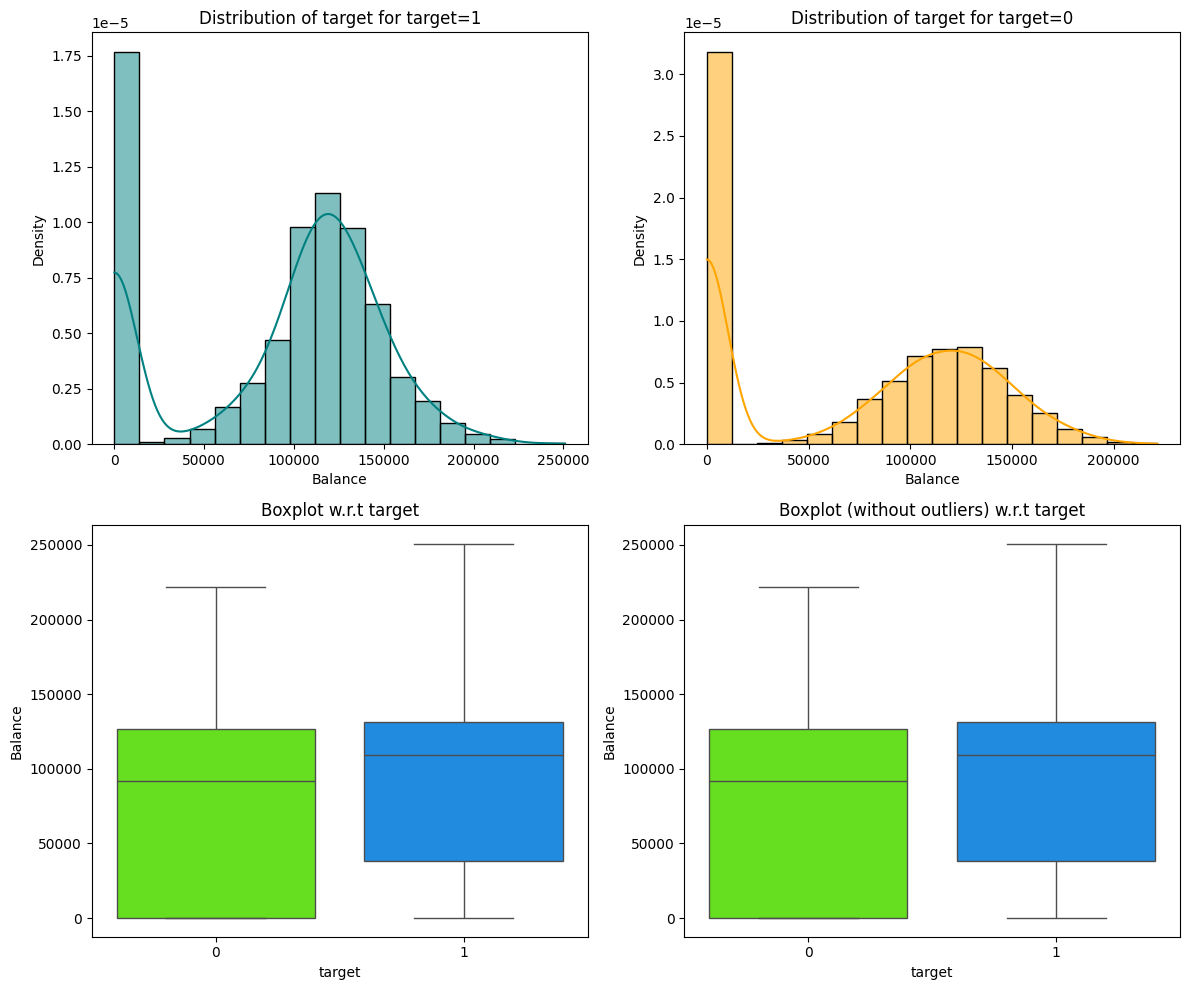

In [ ]:
distribution_plot_wrt_target(data, "Balance", "target")

Observation
* Mean of the balance of customers who left the bank is higher. Slightly over 100000.
* Customer who has balance of 40K to 125K has higher chances of churn.
* Data indicate, in general, lower balance customers are staying with the bank.
* Suggest to the bank to run some campaigns for customers who have 50K or higher balance and try to increase customer satisfaction.


#### Target vs. ZeroBalance customers

ZeroBalance     0     1    All
target                        
All          6383  3617  10000
0            4846  3117   7963
1            1537   500   2037
------------------------------------------------------------------------------------------------------------------------


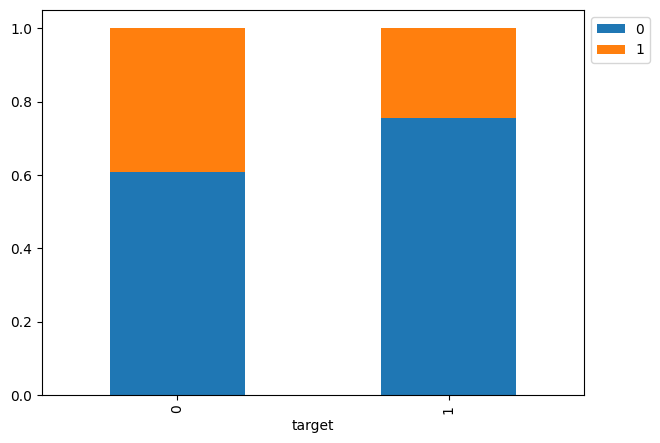

In [ ]:
stacked_barplot(data, 'target', 'ZeroBalance')

Observation
* Lower chance of churn with Zero Balance customers

#### Target vs EstimatedSalary

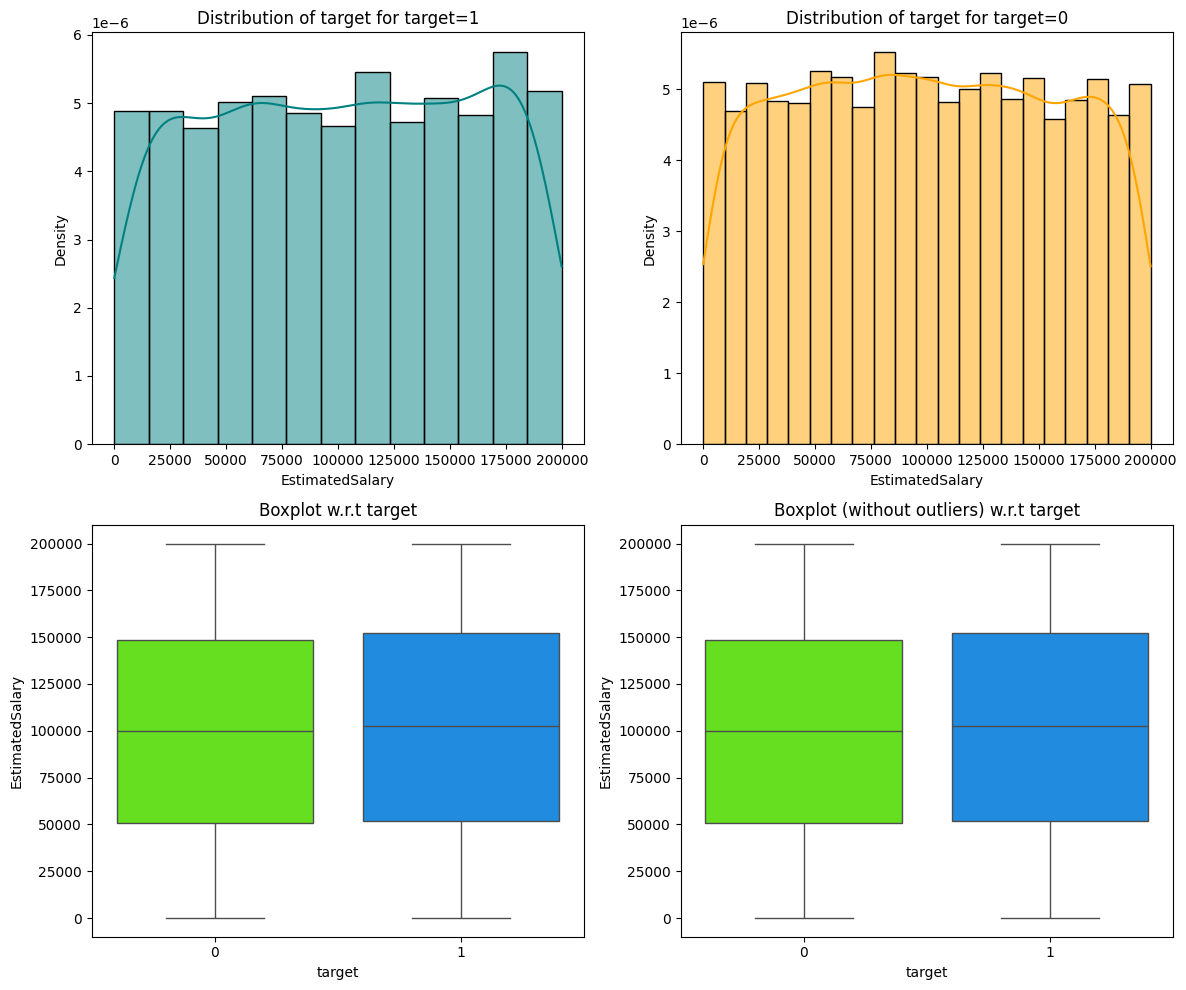

In [ ]:
distribution_plot_wrt_target(data, "EstimatedSalary", "target")

Observation
* Estimated Salary do not have much impact on churn.
* Same distribution across both types of customers.

#### Target vs NumOfProducts

NumOfProducts     1     2    3   4    All
target                                   
1              1409   348  220  60   2037
All            5084  4590  266  60  10000
0              3675  4242   46   0   7963
------------------------------------------------------------------------------------------------------------------------


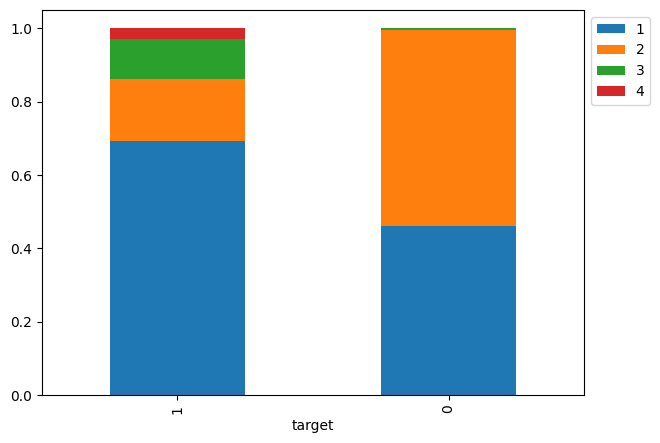

In [ ]:
stacked_barplot(data, 'target', 'NumOfProducts')

Observation

* Number of products does play some role in churn.
* 70% of customers who left the bank has only one product service with the bank.
* Also, if customers have 2 or more products from the bank then they have very high chances of leaving the bank.
* Bank should run some surveys to get feedback on their customer service.

### Further Analysis

In [ ]:
customers_count_1 = data[(data['IsActiveMember'] == 0) & (data['HasCrCard'] == 1) & (data['target'] == 1)].shape[0]
print("Count of inactive members with a credit card who have exited:", customers_count_1)

customers_count_2 = data[(data['HasCrCard'] == 1) & (data['target'] == 1)].shape[0]
print("Count of customers who had a credit card who have exited:", customers_count_2)

Count of inactive members with a credit card who have exited: 942
Count of customers who had a credit card who have exited: 1424


Observation
* 942 customers who are inactive members and have credit card left the bank.
* 1424 customers who had a credit card who have exited the bank

In [ ]:
customers_count_3 = data[(data['NumOfProducts'] > 1) & (data['HasCrCard'] == 1) & (data['target'] == 1)].shape[0]
print("Count of customers with more than 1 product, a credit card, who have exited:", customers_count_3)

customers_count_4 = data[(data['NumOfProducts'] == 1) & (data['HasCrCard'] == 0) & (data['target'] == 1)].shape[0]
print("Count of customers who didnt have credit card but had a different product service but still exited:", customers_count_4)

Count of customers with more than 1 product, a credit card, who have exited: 433
Count of customers who didnt have credit card but had a different product service but still exited: 418


Observation
* 433 customers who had more than one product service including credit card left the bank.
* 418 customers who had no credit card but had a different type product service and still they left the bank. Need further data what type of product service these 418 customer had.

In [ ]:
customers_count_5 = data[(data['NumOfProducts'] == 1) & (data['HasCrCard'] == 1) & (data['target'] == 1)].shape[0]

print("Count of customers with more than 1 product, a credit card, who have exited:", customers_count_5)

Count of customers with more than 1 product, a credit card, who have exited: 991


In [ ]:
customers_count_6 = data[(data['Geography'] == 'Germany') & (data['target'] == 1)].shape[0]
print("Count of customers from Germany, who have exited:", customers_count_6)

customers_count_7 = data[(data['Geography'] == 'Germany') & (data['HasCrCard'] == 1) & (data['target'] == 1)].shape[0]
print("Count of customers with credit card and from Germany, who have exited:", customers_count_7)

Count of customers from Germany, who have exited: 814
Count of customers with credit card and from Germany, who have exited: 577


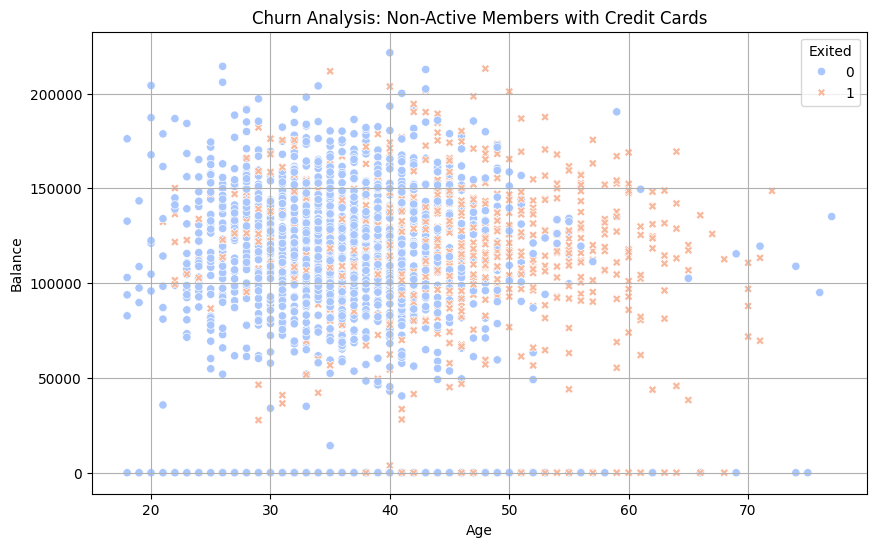

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataset based on the conditions
filtered_data = data[(data['IsActiveMember'] == 0) & (data['HasCrCard'] == 1)]

# Create a scatter plot of 'Age' versus 'Balance' with hue based on 'Exited'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='Age', y='Balance', hue='target', style='target', palette='coolwarm', markers=True)

plt.title('Churn Analysis: Non-Active Members with Credit Cards')
plt.xlabel('Age')
plt.ylabel('Balance')
plt.legend(title='Exited')
plt.grid(True)
plt.show()


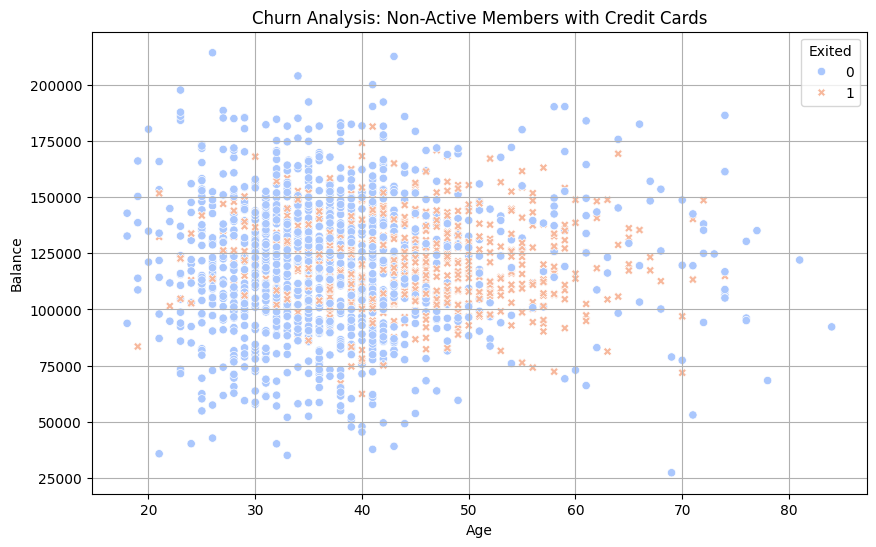

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataset based on the conditions
filtered_data2 = data[(data['Geography'] == 'Germany') & (data['HasCrCard'] == 1)]

# Create a scatter plot of 'Age' versus 'Balance' with hue based on 'Exited'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data2, x='Age', y='Balance', hue='target', style='target', palette='coolwarm', markers=True)

plt.title('Churn Analysis: Non-Active Members with Credit Cards')
plt.xlabel('Age')
plt.ylabel('Balance')
plt.legend(title='Exited')
plt.grid(True)
plt.show()


In [ ]:
# # Filter the dataset based on the conditions
# filtered_data = data[(data['HasCrCard'] == 1) & (data['NumOfProducts'] > 1)]

# # Group by 'HasCrCard' and 'NumOfProducts' and calculate mean values for numerical columns
# grouped_data = filtered_data.groupby(['HasCrCard', 'NumOfProducts'])

# Display the grouped data
# grouped_data


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Filter the dataset based on the conditions
# filtered_data = data[(data['HasCrCard'] == 1) & (data['NumOfProducts'] > 1)]

# Create a scatter plot of 'Age' versus 'Balance' with hue based on 'Exited'
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=filtered_data, x='Age', y='Balance', hue='target', style='target', palette='viridis', markers=True)

# plt.title('Customer Churn: Age vs Balance')
# plt.xlabel('Age')
# plt.ylabel('Balance')
# plt.legend(title='Exited')
# plt.show()


In [ ]:
# !pip install nbconvert

In [ ]:
# To convert notebook in to html file run following code. It will save html file in same location as notebook
# !jupyter nbconvert --to html '/content/drive/MyDrive/GreatLearning/Rahul_INN_Bank_Churn_FullCode_Notebook.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/GreatLearning/Rahul_INN_Bank_Churn_FullCode_Notebook.ipynb to html
[NbConvertApp] Writing 4702629 bytes to /content/drive/MyDrive/GreatLearning/Rahul_INN_Bank_Churn_FullCode_Notebook.html
